In [1]:
%matplotlib inline
import fleks,yt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import stats
import numpy as np
import os
import re
from utilities import get_ticks
from matplotlib import cm, ticker
from os import listdir
from os.path import isfile, join
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import interpolate
from matplotlib.ticker import LogFormatter 
from matplotlib.ticker import LogLocator, LogFormatterSciNotation 

mu_0 = 1.257e-6
R_M = 2440e3 #m

ModuleNotFoundError: No module named 'fleks'

# Save frame slices for making movies

In [149]:
#########################

# High-level user input
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/"    # Directory with data 
start_time = 135                                                # What is the start time of the dataset?
t_bound = [135,303]                                               # Start and stop times for the GIF
dt = 0.2                                                     # What is the timestep between files?

'''
Choose plot type from existing presets;

"pic_E_y":  flow vectors and duskward convective field
Recommended settings: (xy)
xlims=[-2.2,0.2]
ylims=[-1.2,1.2]
shape=[160,160]

"pic_dipolarization_zoom": pressure and field lines to show particular dipolarization event in detail
Recommended settings: (xz)
xlims=[-3,-0.75]
ylims=[-0.5,1.0]
shape=[225,150] 

"pic_Jy": find xz line of the current sheet (xz)
Recommended settings: (xz)
xlims=[-3,-0.75]
ylims=[-0.5,1.0]
shape=[225,150] 

"pic_currentsheet": eletric field and Bz in current sheet
Recommended settings: (xz)
xlims=[-3.5,0.2]
ylims=[-1.2,1.2]
shape=[160,160] 

"bz1": perturbation magnetic field in near-planet current sheet (xy)
xlims=[-2.4,-0.4]
ylims=[-1,1]
shape=[200,200] 

"pressure_anisotropy": plot of pressure difference between perpendicular and parallel
xlims=[-2.4,-0.4]
ylims=[-1,1]
shape=[200,200] 

"pic_currentsheet2": just bz in the current sheet (xy)
xlims=[-2.2,0.2]
ylims=[-1.2,1.2]
shape=[160,160] 
'''

plot_preset = "pic_Jy"
slice = "xz"                                                   # Set plane of slice ("xy" or "xz") or "sphere" for particle psd
data_type = "fluid" # "cut" or "fluid"
particle_type = "ion" # Either "ion" or "electron"; relevant for choosing which pressure tensor to display for "pressure_anisotropy"
z_plane = 0.35

# Grid settings/location of particle sphere
xlims=[-3,-0.75]
ylims=[-0.5,1.0]
shape=[225,150] 
loc = [-1.0,0,0.2] # location of particle sphere
a = 0.1 # radius of particle sphere

#########################

# First, get list of files in directory
all_files = [os.path.join(dir, o) for o in os.listdir(dir) 
                    if os.path.isdir(os.path.join(dir,o))]

# Then use regex to pick out only the files we want 
files=[]
for file in all_files:
    if data_type=="fluid":
        match = re.search(str(dir+"3d_fluid_region0_.*"),file)
        if match != None:
            files.append(file)
    elif data_type=="cut":
        match = re.search(str(dir+"cut_particle_region0.*"),file)
        if match != None:
            files.append(file)
files.sort()
files = files
print(str(len(files)),"files recognized!")

# Make a dictionary with better names for the files:
named_files = {}
for i in range(len(files)):
    time = round(i*dt+start_time,3)
    named_files[time] = files[i]

# Define utility functions
def get_grad(slice,i_coords,j_coords):
    # Input: a numpy-format slice of the data, in the right orientation such that imshow / contourf works correctly. 
    # Also pass dc.x.value, dc.y.value to give the i / j coords.
    # Output: the gradient of the parameter, in the i / j direction (i.e. x,y or x,z), whichever plane the slice is in.
    
    # Extract the j and i dimensions 
    j_size,i_size = slice.shape

    # Find step size
    di = i_coords[1]-i_coords[0]
    dj = j_coords[1]-j_coords[0]

    # Define empty arrays to save output to
    d_di = np.zeros_like(slice)
    d_dj = np.zeros_like(slice)

    # First past compute gradient (error: huge gradients at edge of boundary e.g bz drops to 0 at inner edge in one cell)
    #d_di,d_dj = np.gradient(slice,di,dj)

    # Begin gradient computation loop
    for j in range(1,j_size-1):
        for i in range(1,i_size-1):
            # Compute d_di:
            d_di[j,i] = (slice[j,i+1] - slice[j,i-1]) / (2*di)
            # Compute d_dj:
            d_dj[j,i] = (slice[j+1,i] - slice[j-1,i]) / (2*dj)

    # Fix large gradients at edges of pic domain
    for j in range(1,j_size-1):
        for i in range(1,i_size-1):
            if slice[j,i]==0 and slice[j,i+1]!=0: # left edge
                d_di[j,i] = 0 # set gradient outside pic to 0
                d_dj[j,i] = 0
                d_di[j,i+1] = d_di[j,i+2] # set outermost cell gradient to same value as one further in
                d_dj[j,i+1] = d_dj[j,i+2]
            if slice[j,i]==0 and slice[j,i-1]!=0: # right edge
                d_di[j,i] = 0 
                d_dj[j,i] = 0
                d_di[j,i-1] = d_di[j,i-2] 
                d_dj[j,i-1] = d_dj[j,i-2]
            if slice[j,i]==0 and slice[j+1,i]!=0: # bottom edge
                d_di[j,i] = 0 
                d_dj[j,i] = 0
                d_di[j+1,i] = d_di[j+2,i] 
                d_dj[j+1,i] = d_dj[j+2,i]
            if slice[j,i]==0 and slice[j-1,i]!=0: # top edge
                d_di[j,i] = 0 
                d_dj[j,i] = 0
                d_di[j-1,i] = d_di[j-2,i] 
                d_dj[j-1,i] = d_dj[j-2,i]
            #print("Value:",slice[j,i],"X:",i_coords[i],"Z:",j_coords[j])
    
    return d_di,d_dj

def gauss(x, *p): #gaussian function used for some fitting
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# Loop over each file, pull the data, make the plots, and save as .pngs in /frames
for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
    filename = str(named_files[time])
    print(filename)
    ds = fleks.load(filename)
    if slice=="xy":
        dc = ds.get_slice("z",z_plane)
        #print(dc)
    elif slice=="xz":
        dc = ds.get_slice("y",0.0)
    elif slice=="sphere":
        ds.add_field(("particle", "unit_one"), function=_unit_one, sampling_type='particle')
    
    # Plot!!

    # Use preset
    if plot_preset == "pic_E_y":
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)
        v = dc.evaluate_expression("Ey")
        ux = np.array(dc.evaluate_expression("uxS1").T)
        uy = np.array(dc.evaluate_expression("uyS1").T)
        vmin = v.min().v
        vmax = v.max().v
        nlevels = 200 
        levels = np.linspace(-50, 50, nlevels)
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(v.T)/1e3, levels=levels, cmap='bwr')
        ticks = get_ticks(-50, 50)
        clb = fig.colorbar(cs, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$E_y$ [mV/m]',fontsize=12)
        quiver_skip=10
        ax.quiver(dc.x.value[::quiver_skip], dc.y.value[::quiver_skip],ux[::quiver_skip,::quiver_skip], uy[::quiver_skip,::quiver_skip],color="grey")
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Convection field at t="+str(round(time,2))+"s"))
        fig.show()

    elif plot_preset == "pic_dipolarization_zoom":
        fig, ax = plt.subplots(figsize=(12,7))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)
        Bx = dc.evaluate_expression("Bx")
        P = dc.evaluate_expression("pxxS1")+dc.evaluate_expression("pyyS1")+dc.evaluate_expression("pzzS1")+dc.evaluate_expression("pxxS0")+dc.evaluate_expression("pyyS0")+dc.evaluate_expression("pzzS0")
        Bz = dc.evaluate_expression("Bz")
        vmin = -2
        vmax = 1.5
        nlevels = 21 
        levels=np.logspace(vmin,vmax,nlevels)
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(P.T),levels=levels,norm = LogNorm())#norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax))#, cmap='bwr')

        start_points = np.zeros([40,2])
        start_points[:,0]=np.linspace(xlims[0],xlims[1],40)
        start_points[:,1]=0.5 - np.linspace(0,0.1,40)
        
        ax.streamplot(dc.x.value,dc.y.value, np.array(Bx.T),np.array(Bz.T),color='white',linewidth=0.5,broken_streamlines=False,arrowsize=0.5,
                      start_points=start_points)
        formatter = LogFormatter(10, labelOnlyBase=False) 
        clb = fig.colorbar(cs, ax=ax,norm=LogNorm())#, format=formatter)            
        clb.locator = LogLocator()
        clb.formatter = LogFormatterSciNotation()
        clb.ax.set_title('p [nPa]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Plasma pressure at t="+str(round(time,2))+"s"))
        fig.show()

    elif plot_preset == "pic_Jy":
        # Set up plot environment
        fig, ax = plt.subplots(figsize=(12,7))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)

        # Read in B field data
        Bx = np.array(dc.evaluate_expression("Bx").T)
        Bz = np.array(dc.evaluate_expression("Bz").T)

        # Compute B-field gradients, converting from nT/R_M to T/m
        dBx_dx, dBx_dz = get_grad(Bx*1e-9/R_M,dc.x.value, dc.y.value)
        dBz_dx, dBz_dz = get_grad(Bz*1e-9/R_M,dc.x.value, dc.y.value)

        # Compute curl [mA / m^2]
        Jy = (dBx_dz-dBz_dx) / mu_0 * 1e6

        # Find line-of-best-fit for region -3<x<-1.2
        x_cs = dc.x.value[dc.x.value>-2.2] # First, get x array
        x_cs = x_cs[x_cs<-1.7]
        y_cs = np.zeros_like(x_cs) # Declare empty y array, which will be used to save y value of current layer center
        for i in range(len(x_cs)): # Iterate over each x bin
            # Get the x index for this bin
            xi = np.where(dc.x.value == x_cs[i])
            # Fit a gaussian to each y / Jy profile, and extract the y coord of the max
            coeff, var_matrix = curve_fit(gauss, dc.y.value, Jy[:,xi].flatten(), p0=[1.,0.,1.])
            fit = gauss(dc.y.value, *coeff)
            #plt.plot(dc.y.value, Jy[:,xi].flatten(), label='Test data')
            #plt.plot(dc.y.value, fit, label='Fitted data')
            #plt.show()
            y_cs[i] = dc.y.value[np.argmax(fit)]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_cs,y_cs)

        # Colorplot
        vmin = -0.5
        vmax = 0.5
        nlevels = 51 
        levels = np.linspace(vmin, vmax, nlevels)
        cs = ax.contourf(dc.x.value, dc.y.value, Jy, levels=levels, cmap='bwr')

        # Add Jy line of best fit
        ax.plot(dc.x.value, slope*dc.x.value+intercept,linestyle="dashed",linewidth=3,alpha=0.5,color="black")

        # Add colorbar
        clb = fig.colorbar(cs, ax=ax)
        clb.ax.set_title('$J_y$ [mA/m$^2$]',fontsize=12)

        # Configure plot plane
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Current density at t="+str(round(time,2))+"s"))
        fig.show()

    elif plot_preset == "pic_currentsheet":
        fig, ax = plt.subplots(ncols=2,figsize=(25,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        #plot v
        v = np.sqrt(dc.evaluate_expression("uxS1")**2 + dc.evaluate_expression("uyS1")**2)
        ux = np.array(dc.evaluate_expression("uxS1").T)
        uy = np.array(dc.evaluate_expression("uyS1").T)
        vmin = v.min().v
        vmax = v.max().v
        nlevels = 200 
        levels = np.logspace(0, 3, nlevels)
        cs = ax[0].contourf(dc.x.value, dc.y.value, np.array(v.T),levels=levels, cmap='rainbow',locator=ticker.LogLocator())
        clb0 = fig.colorbar(cs, ax=ax[0])                   
        clb0.ax.tick_params(labelsize=8)
        clb0.ax.set_title('$V$ [R$_M$/s]',fontsize=12)
        quiver_skip=10
        ax[0].quiver(dc.x.value[::quiver_skip], dc.y.value[::quiver_skip],ux[::quiver_skip,::quiver_skip], uy[::quiver_skip,::quiver_skip],color="grey")
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]")
        ax[0].set_ylabel("Y [$R_M$]")
        ax[0].add_patch(outer)
        ax[0].add_patch(inner)
        ax[0].set_xlim(xlims)
        ax[0].set_ylim(ylims)
        ax[0].set_title(str("Convection field at t="+str(round(time,2))+"s"))

        #plot B
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        Bx = dc.evaluate_expression("Bx")
        Bz = dc.evaluate_expression("Bz")
        vmin = -100
        vmax = 100
        nlevels = 200 
        levels = np.linspace(vmin, vmax, nlevels)
        cs = ax[1].contourf(dc.x.value, dc.y.value, np.array(Bz.T), levels=levels, cmap='bwr')
        
        ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs, ax=ax[1],ticks=ticks)            
        clb1.ax.set_yticks(ticks)    
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$B_z$ [nT]',fontsize=12)
        ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1].set_xlabel("X [$R_M$]")
        ax[1].set_ylabel("Y [$R_M$]")
        ax[1].add_patch(outer)
        ax[1].add_patch(inner)
        ax[1].set_xlim(xlims)
        ax[1].set_ylim(ylims)
        ax[1].set_title(str("$B_z$ at t="+str(round(time,2))+"s"))

    elif plot_preset == "particles_uxuy":
        # broken for many reasons, and the particle data is featureless anyway.
        sp = ds.sphere(loc,a)
        plot = ds.plot_phase_region(sp, 'p_ux', 'p_uz', z_field,
                            unit_type="planet", x_bins=64, y_bins=64,domain_size=(-2550, 2550, -2550, 2550))
        #plot.set_colorbar_label(plot.fields[0], "Ion count")
        for var_name in plot.profile.field_data: 
            val = plot.profile.field_data[var_name] 
    
        x = plot.profile.x
        y = plot.profile.y

        fig, ax = plt.subplots(figsize=(10,10))
        im = ax.contourf(x,y,val,20,vmin = 0,vmax=700)
        im.set_clim(0,700)
        clb=fig.colorbar(im)

    elif plot_preset == "pic_currentsheet2":
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)
        Bz = dc.evaluate_expression("Bz")
        vmin = -100
        vmax = 100
        nlevels = 200 
        levels = np.linspace(vmin, vmax, nlevels)
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(Bz.T), levels=levels, cmap='bwr')

        # Add minor ticks for grid
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.2)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.2)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        ticks = get_ticks(vmin, vmax)
        clb = fig.colorbar(cs, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_{z}$ at t="+str(round(time,2))+"s"+"   z = "+str(z_plane)))
        fig.show()

    elif plot_preset == "bz1":
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)

        # Extract Bz and remove units
        Bz_temp = dc.evaluate_expression("Bz")
        Bz = np.zeros(Bz_temp.shape)
        Bz[:,:] = Bz_temp[:,:]

        # Define meshgrids
        xx,yy = np.meshgrid(dc.x.value, dc.y.value)

        #Compute Bz1 
        #First compute dipole field strength, from https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
        Bz_dip = - 200.9 * (3*z_plane**2 - (xx**2+yy**2+z_plane**2))/((xx**2+yy**2+z_plane**2)**(5/2))
        # Then subtract this from modeled bz
        Bz1 = Bz.T - Bz_dip
        
        vmin = -100#-100
        vmax = 20
        nlevels = 91 
        levels = np.linspace(vmin, vmax, nlevels)
        
        cs1 = ax.contourf(dc.x.value, dc.y.value, np.array(Bz1), cmap = 'viridis',levels=levels) #,cmap='bwr')
        cs2 = ax.contour(dc.x.value, dc.y.value, np.array(Bz.T),levels=[0],colors="white",linewidths=1) #,cmap='bwr')

        # Add minor ticks for grid
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.2)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.2)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        ticks = get_ticks(vmin, vmax)
        clb = fig.colorbar(cs1, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_{z1}$ at t="+str(round(time,2))+"s"+"   z = "+str(z_plane)))
        fig.show()

    elif plot_preset == "pressure_anisotropy":
        
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        print("Plotting t",time)
        
        # Extract pressure terms and remove units
        if particle_type=="ion":
            pxxS1_temp = dc.evaluate_expression("pxxS1")
            pxyS1_temp = dc.evaluate_expression("pxyS1")
            pxzS1_temp = dc.evaluate_expression("pxzS1")
            pyyS1_temp = dc.evaluate_expression("pyyS1")
            pyzS1_temp = dc.evaluate_expression("pyzS1")
            pzzS1_temp = dc.evaluate_expression("pzzS1")
        elif particle_type=="electron":
            pxxS1_temp = dc.evaluate_expression("pxxS0")
            pxyS1_temp = dc.evaluate_expression("pxyS0")
            pxzS1_temp = dc.evaluate_expression("pxzS0")
            pyyS1_temp = dc.evaluate_expression("pyyS0")
            pyzS1_temp = dc.evaluate_expression("pyzS0")
            pzzS1_temp = dc.evaluate_expression("pzzS0")
        else:
            print("ERROR: invalid particle type!")
        pxxS1 = np.zeros(pxxS1_temp.T.shape)
        pxyS1 = np.zeros(pxyS1_temp.T.shape)
        pxzS1 = np.zeros(pxzS1_temp.T.shape)
        pyyS1 = np.zeros(pyyS1_temp.T.shape)
        pyzS1 = np.zeros(pyzS1_temp.T.shape)
        pzzS1 = np.zeros(pzzS1_temp.T.shape)
        pxxS1[:,:] = pxxS1_temp[:,:].T
        pxyS1[:,:] = pxyS1_temp[:,:].T
        pxzS1[:,:] = pxyS1_temp[:,:].T
        pyyS1[:,:] = pyyS1_temp[:,:].T
        pyzS1[:,:] = pyzS1_temp[:,:].T
        pzzS1[:,:] = pzzS1_temp[:,:].T

        # Extract magnetic terms and remove units
        Bx_temp = dc.evaluate_expression("Bx")
        By_temp = dc.evaluate_expression("By")
        Bz_temp = dc.evaluate_expression("Bz")
        Bx = np.zeros(Bx_temp.T.shape)
        By = np.zeros(By_temp.T.shape)
        Bz = np.zeros(Bz_temp.T.shape)
        Bx[:,:] = Bx_temp[:,:].T
        By[:,:] = By_temp[:,:].T
        Bz[:,:] = Bz_temp[:,:].T

        # Define meshgrids
        xx,yy = np.meshgrid(dc.x.value, dc.y.value)

        # Compute magnetic unit vector
        B_mag = np.sqrt(Bx**2+By**2+Bz**2)
        bx,by,bz = 1/B_mag * [Bx,By,Bz]

        # Compute coordinate transformation matrix, A
        # The three columns of this matrix correspond to the first perpendicular component, the second, and the parallel component, respectively
        Axx = np.sqrt(1-bx**2)
        Axy = 0
        Axz = bx
        Ayx = -bx*by/np.sqrt(1-bx**2)
        Ayy = bz/np.sqrt(bz**2+by**2)
        Ayz = by
        Azx = -bx*bz/np.sqrt(1-bx**2)
        Azy = -by/np.sqrt(bz**2+by**2)
        Azz = bz

        # Transfrom the pressure tensor from pS1 (in cartesian) to P (in perp / perp / parallel coords): P = A x pS1
        # Note that pS1 is symmetric, so e.g. pxyS1 = pyxS1
        Pxx = Axx*pxxS1 + Axy*pxyS1 + Axz*pxzS1
        Pxy = Axx*pxyS1 + Axy*pyyS1 + Axz*pyzS1
        Pxz = Axx*pxzS1 + Axy*pyzS1 + Axz*pzzS1
        Pyx = Ayx*pxxS1 + Ayy*pxyS1 + Ayz*pxzS1
        Pyy = Ayx*pxyS1 + Ayy*pyyS1 + Ayz*pyzS1
        Pyz = Ayx*pxzS1 + Ayy*pyzS1 + Ayz*pzzS1
        Pzx = Azx*pxxS1 + Azy*pxyS1 + Azz*pxzS1
        Pzy = Azx*pxyS1 + Azy*pyyS1 + Azz*pyzS1
        Pzz = Azx*pxzS1 + Azy*pyzS1 + Azz*pzzS1

        # For now, we are interested in the difference parallel (Pzz) and perpendicular (Pxx and Pyy)
        P_anisotropy = Pzz - Pxx - Pyy / np.sqrt(Pzz**2+Pxx**2+Pyy**2)

        # Plot
        vmin = -1.5
        vmax = 1.5
        nlevels = 200 
        levels = np.linspace(vmin, vmax, nlevels)
        
        cs = ax.contourf(dc.x.value, dc.y.value, np.array(P_anisotropy), levels=levels, cmap='bwr')

        # Add minor ticks for grid
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.2)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.2)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        ticks = get_ticks(vmin, vmax)
        clb = fig.colorbar(cs, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('Normalized diff',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("parallel - perpendicular at t="+str(round(time,2))+"s"+"   z = "+str(z_plane))+"\n Particle type: "+particle_type)
        fig.show()
        
    # Save
    plt.savefig(str("/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun_plots/"+plot_preset+"_"+str(round(time,2))+'.png'),bbox_inches='tight')
    plt.close(fig)

yt : [INFO     ] 2024-08-12 16:27:29,360 Parameters: current_time              = 135.0
yt : [INFO     ] 2024-08-12 16:27:29,361 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:29,361 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:29,362 Parameters: domain_right_edge         = [1. 2. 2.]


142 files recognized!
/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000215_n00000000_amrex
Plotting t 135.0


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_69318/3294814908.py:289: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
yt : [INFO     ] 2024-08-12 16:27:30,925 Parameters: current_time              = 135.20000868810553
yt : [INFO     ] 2024-08-12 16:27:30,925 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:30,926 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:30,927 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000215_n00000104_amrex
Plotting t 135.2


yt : [INFO     ] 2024-08-12 16:27:31,817 Parameters: current_time              = 135.40176287854825
yt : [INFO     ] 2024-08-12 16:27:31,818 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:31,819 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:31,819 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000215_n00000216_amrex
Plotting t 135.4


yt : [INFO     ] 2024-08-12 16:27:32,709 Parameters: current_time              = 135.6001333963198
yt : [INFO     ] 2024-08-12 16:27:32,709 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:32,710 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:32,711 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000215_n00000324_amrex
Plotting t 135.6


yt : [INFO     ] 2024-08-12 16:27:33,871 Parameters: current_time              = 135.80092812998905
yt : [INFO     ] 2024-08-12 16:27:33,872 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:33,873 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:33,873 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000215_n00000438_amrex
Plotting t 135.8


yt : [INFO     ] 2024-08-12 16:27:35,115 Parameters: current_time              = 136.00133957449802
yt : [INFO     ] 2024-08-12 16:27:35,116 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:35,117 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:35,117 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000216_n00000549_amrex
Plotting t 136.0


yt : [INFO     ] 2024-08-12 16:27:36,320 Parameters: current_time              = 136.2010620222566
yt : [INFO     ] 2024-08-12 16:27:36,321 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:36,321 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:36,322 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000216_n00000656_amrex
Plotting t 136.2


yt : [INFO     ] 2024-08-12 16:27:37,529 Parameters: current_time              = 136.4014282815098
yt : [INFO     ] 2024-08-12 16:27:37,530 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:37,531 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:37,531 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000216_n00000766_amrex
Plotting t 136.4


yt : [INFO     ] 2024-08-12 16:27:38,720 Parameters: current_time              = 136.60141536902086
yt : [INFO     ] 2024-08-12 16:27:38,721 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:38,722 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:38,723 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000216_n00000876_amrex
Plotting t 136.6


yt : [INFO     ] 2024-08-12 16:27:39,885 Parameters: current_time              = 136.8015747048821
yt : [INFO     ] 2024-08-12 16:27:39,885 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:39,886 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:39,887 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000216_n00000981_amrex
Plotting t 136.8


yt : [INFO     ] 2024-08-12 16:27:41,920 Parameters: current_time              = 137.0007829797857
yt : [INFO     ] 2024-08-12 16:27:41,921 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:41,922 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:41,923 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000217_n00001083_amrex
Plotting t 137.0


yt : [INFO     ] 2024-08-12 16:27:43,116 Parameters: current_time              = 137.20097049042084
yt : [INFO     ] 2024-08-12 16:27:43,117 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:43,117 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:43,118 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000217_n00001187_amrex
Plotting t 137.2


yt : [INFO     ] 2024-08-12 16:27:44,293 Parameters: current_time              = 137.40030227361433
yt : [INFO     ] 2024-08-12 16:27:44,294 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:44,295 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:44,295 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000217_n00001286_amrex
Plotting t 137.4


yt : [INFO     ] 2024-08-12 16:27:45,454 Parameters: current_time              = 137.60161285777713
yt : [INFO     ] 2024-08-12 16:27:45,455 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:45,456 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:45,457 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000217_n00001391_amrex
Plotting t 137.6


yt : [INFO     ] 2024-08-12 16:27:46,613 Parameters: current_time              = 137.80172372155434
yt : [INFO     ] 2024-08-12 16:27:46,614 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:46,615 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:46,616 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000217_n00001496_amrex
Plotting t 137.8


yt : [INFO     ] 2024-08-12 16:27:47,769 Parameters: current_time              = 138.0003495439726
yt : [INFO     ] 2024-08-12 16:27:47,770 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:47,770 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:47,771 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000218_n00001597_amrex
Plotting t 138.0


yt : [INFO     ] 2024-08-12 16:27:48,935 Parameters: current_time              = 138.20077534179643
yt : [INFO     ] 2024-08-12 16:27:48,936 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:48,937 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:48,938 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000218_n00001702_amrex
Plotting t 138.2


yt : [INFO     ] 2024-08-12 16:27:50,112 Parameters: current_time              = 138.4009871673815
yt : [INFO     ] 2024-08-12 16:27:50,113 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:50,114 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:50,115 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000218_n00001808_amrex
Plotting t 138.4


yt : [INFO     ] 2024-08-12 16:27:51,286 Parameters: current_time              = 138.60069832807923
yt : [INFO     ] 2024-08-12 16:27:51,287 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:51,288 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:51,288 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000218_n00001915_amrex
Plotting t 138.6


yt : [INFO     ] 2024-08-12 16:27:52,442 Parameters: current_time              = 138.8015772260759
yt : [INFO     ] 2024-08-12 16:27:52,443 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:52,444 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:52,445 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000218_n00002022_amrex
Plotting t 138.8


yt : [INFO     ] 2024-08-12 16:27:54,521 Parameters: current_time              = 139.00017845735312
yt : [INFO     ] 2024-08-12 16:27:54,522 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:54,522 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:54,523 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000219_n00002126_amrex
Plotting t 139.0


yt : [INFO     ] 2024-08-12 16:27:55,694 Parameters: current_time              = 139.20131008404218
yt : [INFO     ] 2024-08-12 16:27:55,695 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:55,696 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:55,696 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000219_n00002232_amrex
Plotting t 139.2


yt : [INFO     ] 2024-08-12 16:27:56,893 Parameters: current_time              = 139.40034366583404
yt : [INFO     ] 2024-08-12 16:27:56,894 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:56,895 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:56,896 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000219_n00002336_amrex
Plotting t 139.4


yt : [INFO     ] 2024-08-12 16:27:58,079 Parameters: current_time              = 139.60066825686016
yt : [INFO     ] 2024-08-12 16:27:58,079 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:58,080 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:58,081 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000219_n00002441_amrex
Plotting t 139.6


yt : [INFO     ] 2024-08-12 16:27:59,278 Parameters: current_time              = 139.8008025357148
yt : [INFO     ] 2024-08-12 16:27:59,279 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:27:59,279 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:27:59,280 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000219_n00002543_amrex
Plotting t 139.8


yt : [INFO     ] 2024-08-12 16:28:00,471 Parameters: current_time              = 140.00169966710527
yt : [INFO     ] 2024-08-12 16:28:00,472 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:00,473 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:00,473 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000220_n00002646_amrex
Plotting t 140.0


yt : [INFO     ] 2024-08-12 16:28:01,657 Parameters: current_time              = 140.2006962442681
yt : [INFO     ] 2024-08-12 16:28:01,658 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:01,658 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:01,659 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000220_n00002752_amrex
Plotting t 140.2


yt : [INFO     ] 2024-08-12 16:28:02,827 Parameters: current_time              = 140.40044192675447
yt : [INFO     ] 2024-08-12 16:28:02,827 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:02,828 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:02,829 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000220_n00002859_amrex
Plotting t 140.4


yt : [INFO     ] 2024-08-12 16:28:03,992 Parameters: current_time              = 140.60174286290095
yt : [INFO     ] 2024-08-12 16:28:03,993 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:03,994 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:03,995 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000220_n00002968_amrex
Plotting t 140.6


yt : [INFO     ] 2024-08-12 16:28:05,194 Parameters: current_time              = 140.8013848862417
yt : [INFO     ] 2024-08-12 16:28:05,194 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:05,195 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:05,196 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000220_n00003077_amrex
Plotting t 140.8


yt : [INFO     ] 2024-08-12 16:28:06,387 Parameters: current_time              = 141.00157379951156
yt : [INFO     ] 2024-08-12 16:28:06,388 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:06,389 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:06,389 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000221_n00003186_amrex
Plotting t 141.0


yt : [INFO     ] 2024-08-12 16:28:08,483 Parameters: current_time              = 141.2015641520777
yt : [INFO     ] 2024-08-12 16:28:08,484 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:08,485 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:08,485 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000221_n00003299_amrex
Plotting t 141.2


yt : [INFO     ] 2024-08-12 16:28:09,673 Parameters: current_time              = 141.4007083411215
yt : [INFO     ] 2024-08-12 16:28:09,675 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:09,675 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:09,676 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000221_n00003411_amrex
Plotting t 141.4


yt : [INFO     ] 2024-08-12 16:28:10,892 Parameters: current_time              = 141.601511176457
yt : [INFO     ] 2024-08-12 16:28:10,893 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:10,893 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:10,894 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000221_n00003527_amrex
Plotting t 141.6


yt : [INFO     ] 2024-08-12 16:28:12,072 Parameters: current_time              = 141.80137737723788
yt : [INFO     ] 2024-08-12 16:28:12,072 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:12,073 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:12,074 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000221_n00003644_amrex
Plotting t 141.8


yt : [INFO     ] 2024-08-12 16:28:13,219 Parameters: current_time              = 142.00081732844532
yt : [INFO     ] 2024-08-12 16:28:13,220 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:13,221 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:13,222 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000222_n00003758_amrex
Plotting t 142.0


yt : [INFO     ] 2024-08-12 16:28:14,369 Parameters: current_time              = 142.20066976785006
yt : [INFO     ] 2024-08-12 16:28:14,370 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:14,370 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:14,371 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000222_n00003874_amrex
Plotting t 142.2


yt : [INFO     ] 2024-08-12 16:28:15,553 Parameters: current_time              = 142.4016677262915
yt : [INFO     ] 2024-08-12 16:28:15,554 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:15,555 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:15,556 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000222_n00003986_amrex
Plotting t 142.4


yt : [INFO     ] 2024-08-12 16:28:16,736 Parameters: current_time              = 142.60121978746525
yt : [INFO     ] 2024-08-12 16:28:16,737 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:16,738 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:16,739 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000222_n00004098_amrex
Plotting t 142.6


yt : [INFO     ] 2024-08-12 16:28:17,945 Parameters: current_time              = 142.8004949906992
yt : [INFO     ] 2024-08-12 16:28:17,945 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:17,946 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:17,947 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000222_n00004213_amrex
Plotting t 142.8


yt : [INFO     ] 2024-08-12 16:28:19,106 Parameters: current_time              = 143.00064196861334
yt : [INFO     ] 2024-08-12 16:28:19,107 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:19,107 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:19,108 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000223_n00004324_amrex
Plotting t 143.0


yt : [INFO     ] 2024-08-12 16:28:20,294 Parameters: current_time              = 143.2003998378862
yt : [INFO     ] 2024-08-12 16:28:20,295 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:20,295 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:20,296 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000223_n00004435_amrex
Plotting t 143.2


yt : [INFO     ] 2024-08-12 16:28:22,434 Parameters: current_time              = 143.40067934724308
yt : [INFO     ] 2024-08-12 16:28:22,434 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:22,435 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:22,436 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000223_n00004548_amrex
Plotting t 143.4


yt : [INFO     ] 2024-08-12 16:28:23,588 Parameters: current_time              = 143.60000660279297
yt : [INFO     ] 2024-08-12 16:28:23,588 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:23,589 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:23,590 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000223_n00004666_amrex
Plotting t 143.6


yt : [INFO     ] 2024-08-12 16:28:24,737 Parameters: current_time              = 143.8006492719654
yt : [INFO     ] 2024-08-12 16:28:24,738 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:24,739 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:24,739 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000223_n00004787_amrex
Plotting t 143.8


yt : [INFO     ] 2024-08-12 16:28:25,886 Parameters: current_time              = 144.0004235325798
yt : [INFO     ] 2024-08-12 16:28:25,886 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:25,887 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:25,888 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000224_n00004905_amrex
Plotting t 144.0


yt : [INFO     ] 2024-08-12 16:28:27,036 Parameters: current_time              = 144.20154674350104
yt : [INFO     ] 2024-08-12 16:28:27,037 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:27,038 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:27,039 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000224_n00005023_amrex
Plotting t 144.2


yt : [INFO     ] 2024-08-12 16:28:28,193 Parameters: current_time              = 144.40015817712427
yt : [INFO     ] 2024-08-12 16:28:28,194 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:28,195 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:28,196 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000224_n00005139_amrex
Plotting t 144.4


yt : [INFO     ] 2024-08-12 16:28:29,352 Parameters: current_time              = 144.60139046091376
yt : [INFO     ] 2024-08-12 16:28:29,353 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:29,353 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:29,354 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000224_n00005260_amrex
Plotting t 144.6


yt : [INFO     ] 2024-08-12 16:28:30,503 Parameters: current_time              = 144.8008971103632
yt : [INFO     ] 2024-08-12 16:28:30,504 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:30,505 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:30,506 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000224_n00005379_amrex
Plotting t 144.8


yt : [INFO     ] 2024-08-12 16:28:31,666 Parameters: current_time              = 145.00027042646266
yt : [INFO     ] 2024-08-12 16:28:31,667 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:31,667 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:31,668 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000225_n00005498_amrex
Plotting t 145.0


yt : [INFO     ] 2024-08-12 16:28:32,860 Parameters: current_time              = 145.20009155006036
yt : [INFO     ] 2024-08-12 16:28:32,860 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:32,861 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:32,862 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000225_n00005614_amrex
Plotting t 145.2


yt : [INFO     ] 2024-08-12 16:28:35,025 Parameters: current_time              = 145.40044878305025
yt : [INFO     ] 2024-08-12 16:28:35,025 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:35,026 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:35,027 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000225_n00005736_amrex
Plotting t 145.4


yt : [INFO     ] 2024-08-12 16:28:36,205 Parameters: current_time              = 145.60126294435332
yt : [INFO     ] 2024-08-12 16:28:36,206 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:36,207 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:36,208 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000225_n00005859_amrex
Plotting t 145.6


yt : [INFO     ] 2024-08-12 16:28:37,371 Parameters: current_time              = 145.80140136063957
yt : [INFO     ] 2024-08-12 16:28:37,372 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:37,373 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:37,373 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000225_n00005978_amrex
Plotting t 145.8


yt : [INFO     ] 2024-08-12 16:28:38,569 Parameters: current_time              = 146.00133439686462
yt : [INFO     ] 2024-08-12 16:28:38,569 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:38,570 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:38,571 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000226_n00006098_amrex
Plotting t 146.0


yt : [INFO     ] 2024-08-12 16:28:39,758 Parameters: current_time              = 146.2012796372959
yt : [INFO     ] 2024-08-12 16:28:39,759 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:39,759 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:39,760 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000226_n00006213_amrex
Plotting t 146.2


yt : [INFO     ] 2024-08-12 16:28:40,934 Parameters: current_time              = 146.40072743240543
yt : [INFO     ] 2024-08-12 16:28:40,935 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:40,936 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:40,936 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000226_n00006334_amrex
Plotting t 146.4


yt : [INFO     ] 2024-08-12 16:28:42,090 Parameters: current_time              = 146.60016642892603
yt : [INFO     ] 2024-08-12 16:28:42,091 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:42,092 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:42,092 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000226_n00006453_amrex
Plotting t 146.6


yt : [INFO     ] 2024-08-12 16:28:43,253 Parameters: current_time              = 146.8008924264645
yt : [INFO     ] 2024-08-12 16:28:43,254 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:43,254 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:43,255 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000226_n00006575_amrex
Plotting t 146.8


yt : [INFO     ] 2024-08-12 16:28:44,457 Parameters: current_time              = 147.00102830659304
yt : [INFO     ] 2024-08-12 16:28:44,458 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:44,459 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:44,459 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000227_n00006696_amrex
Plotting t 147.0


yt : [INFO     ] 2024-08-12 16:28:45,646 Parameters: current_time              = 147.20060475423165
yt : [INFO     ] 2024-08-12 16:28:45,647 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:45,648 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:45,648 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000227_n00006814_amrex
Plotting t 147.2


yt : [INFO     ] 2024-08-12 16:28:46,830 Parameters: current_time              = 147.40065356986747
yt : [INFO     ] 2024-08-12 16:28:46,831 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:46,832 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:46,833 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000227_n00006929_amrex
Plotting t 147.4


yt : [INFO     ] 2024-08-12 16:28:49,006 Parameters: current_time              = 147.6013816757867
yt : [INFO     ] 2024-08-12 16:28:49,007 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:49,008 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:49,008 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000227_n00007048_amrex
Plotting t 147.6


yt : [INFO     ] 2024-08-12 16:28:50,202 Parameters: current_time              = 147.80007285999477
yt : [INFO     ] 2024-08-12 16:28:50,203 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:50,204 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:50,204 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000227_n00007165_amrex
Plotting t 147.8


yt : [INFO     ] 2024-08-12 16:28:51,364 Parameters: current_time              = 148.00040071986678
yt : [INFO     ] 2024-08-12 16:28:51,365 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:51,366 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:51,366 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000228_n00007286_amrex
Plotting t 148.0


yt : [INFO     ] 2024-08-12 16:28:52,527 Parameters: current_time              = 148.20078426578567
yt : [INFO     ] 2024-08-12 16:28:52,528 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:52,529 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:52,530 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000228_n00007400_amrex
Plotting t 148.2


yt : [INFO     ] 2024-08-12 16:28:53,689 Parameters: current_time              = 148.40079057624
yt : [INFO     ] 2024-08-12 16:28:53,690 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:53,691 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:53,691 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000228_n00007520_amrex
Plotting t 148.4


yt : [INFO     ] 2024-08-12 16:28:54,860 Parameters: current_time              = 148.6004757783201
yt : [INFO     ] 2024-08-12 16:28:54,861 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:54,861 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:54,862 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000228_n00007639_amrex
Plotting t 148.6


yt : [INFO     ] 2024-08-12 16:28:56,028 Parameters: current_time              = 148.80001096458946
yt : [INFO     ] 2024-08-12 16:28:56,028 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:56,029 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:56,030 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000228_n00007754_amrex
Plotting t 148.8


yt : [INFO     ] 2024-08-12 16:28:57,193 Parameters: current_time              = 149.0000734165961
yt : [INFO     ] 2024-08-12 16:28:57,194 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:57,194 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:57,195 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000229_n00007865_amrex
Plotting t 149.0


yt : [INFO     ] 2024-08-12 16:28:58,358 Parameters: current_time              = 149.2003252758984
yt : [INFO     ] 2024-08-12 16:28:58,359 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:58,360 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:58,360 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000229_n00007975_amrex
Plotting t 149.2


yt : [INFO     ] 2024-08-12 16:28:59,506 Parameters: current_time              = 149.40072738117814
yt : [INFO     ] 2024-08-12 16:28:59,507 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:28:59,507 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:28:59,508 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000229_n00008085_amrex
Plotting t 149.4


yt : [INFO     ] 2024-08-12 16:29:00,660 Parameters: current_time              = 149.6015566193966
yt : [INFO     ] 2024-08-12 16:29:00,661 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:00,662 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:00,662 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000229_n00008202_amrex
Plotting t 149.6


yt : [INFO     ] 2024-08-12 16:29:01,823 Parameters: current_time              = 149.80082493924567
yt : [INFO     ] 2024-08-12 16:29:01,824 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:01,824 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:01,825 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000229_n00008313_amrex
Plotting t 149.8


yt : [INFO     ] 2024-08-12 16:29:03,994 Parameters: current_time              = 150.00148673941126
yt : [INFO     ] 2024-08-12 16:29:03,995 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:03,995 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:03,996 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000230_n00008439_amrex
Plotting t 150.0


yt : [INFO     ] 2024-08-12 16:29:05,146 Parameters: current_time              = 150.2005521138444
yt : [INFO     ] 2024-08-12 16:29:05,147 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:05,148 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:05,148 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000230_n00008553_amrex
Plotting t 150.2


yt : [INFO     ] 2024-08-12 16:29:06,325 Parameters: current_time              = 150.400015659628
yt : [INFO     ] 2024-08-12 16:29:06,326 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:06,327 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:06,327 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000230_n00008668_amrex
Plotting t 150.4


yt : [INFO     ] 2024-08-12 16:29:07,485 Parameters: current_time              = 150.6000693753373
yt : [INFO     ] 2024-08-12 16:29:07,485 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:07,486 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:07,487 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000230_n00008790_amrex
Plotting t 150.6


yt : [INFO     ] 2024-08-12 16:29:08,668 Parameters: current_time              = 150.80108070368905
yt : [INFO     ] 2024-08-12 16:29:08,669 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:08,670 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:08,671 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000230_n00008913_amrex
Plotting t 150.8


yt : [INFO     ] 2024-08-12 16:29:09,835 Parameters: current_time              = 151.00039844126414
yt : [INFO     ] 2024-08-12 16:29:09,836 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:09,836 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:09,837 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000231_n00009032_amrex
Plotting t 151.0


yt : [INFO     ] 2024-08-12 16:29:11,450 Parameters: current_time              = 151.20089165283974
yt : [INFO     ] 2024-08-12 16:29:11,451 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:11,452 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:11,452 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000231_n00009154_amrex
Plotting t 151.2


yt : [INFO     ] 2024-08-12 16:29:12,984 Parameters: current_time              = 151.40112448269443
yt : [INFO     ] 2024-08-12 16:29:12,985 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:12,986 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:12,987 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000231_n00009278_amrex
Plotting t 151.4


yt : [INFO     ] 2024-08-12 16:29:14,159 Parameters: current_time              = 151.6011499981376
yt : [INFO     ] 2024-08-12 16:29:14,160 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:14,160 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:14,161 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000231_n00009398_amrex
Plotting t 151.6


yt : [INFO     ] 2024-08-12 16:29:15,343 Parameters: current_time              = 151.8010785256923
yt : [INFO     ] 2024-08-12 16:29:15,344 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:15,344 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:15,345 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000231_n00009517_amrex
Plotting t 151.8


yt : [INFO     ] 2024-08-12 16:29:16,523 Parameters: current_time              = 152.00040762804448
yt : [INFO     ] 2024-08-12 16:29:16,524 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:16,525 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:16,525 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000232_n00009632_amrex
Plotting t 152.0


yt : [INFO     ] 2024-08-12 16:29:18,755 Parameters: current_time              = 152.20043437568592
yt : [INFO     ] 2024-08-12 16:29:18,755 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:18,756 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:18,756 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000232_n00009744_amrex
Plotting t 152.2


yt : [INFO     ] 2024-08-12 16:29:19,940 Parameters: current_time              = 152.4005159001462
yt : [INFO     ] 2024-08-12 16:29:19,941 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:19,942 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:19,942 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000232_n00009850_amrex
Plotting t 152.4


yt : [INFO     ] 2024-08-12 16:29:21,112 Parameters: current_time              = 152.6001298117408
yt : [INFO     ] 2024-08-12 16:29:21,113 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:21,114 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:21,114 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000232_n00009953_amrex
Plotting t 152.6


yt : [INFO     ] 2024-08-12 16:29:22,302 Parameters: current_time              = 152.8016493348407
yt : [INFO     ] 2024-08-12 16:29:22,302 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:22,303 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:22,304 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000232_n00010058_amrex
Plotting t 152.8


yt : [INFO     ] 2024-08-12 16:29:23,495 Parameters: current_time              = 153.00086385175481
yt : [INFO     ] 2024-08-12 16:29:23,496 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:23,497 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:23,497 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000233_n00010164_amrex
Plotting t 153.0


yt : [INFO     ] 2024-08-12 16:29:24,683 Parameters: current_time              = 153.2003512381722
yt : [INFO     ] 2024-08-12 16:29:24,684 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:24,684 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:24,685 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000233_n00010274_amrex
Plotting t 153.2


yt : [INFO     ] 2024-08-12 16:29:25,988 Parameters: current_time              = 153.4014226082125
yt : [INFO     ] 2024-08-12 16:29:25,989 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:25,990 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:25,990 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000233_n00010390_amrex
Plotting t 153.4


yt : [INFO     ] 2024-08-12 16:29:27,232 Parameters: current_time              = 153.6017315103743
yt : [INFO     ] 2024-08-12 16:29:27,233 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:27,234 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:27,234 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000233_n00010505_amrex
Plotting t 153.6


yt : [INFO     ] 2024-08-12 16:29:28,425 Parameters: current_time              = 153.80134965200205
yt : [INFO     ] 2024-08-12 16:29:28,426 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:28,427 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:28,427 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000233_n00010620_amrex
Plotting t 153.8


yt : [INFO     ] 2024-08-12 16:29:29,606 Parameters: current_time              = 154.00058372677896
yt : [INFO     ] 2024-08-12 16:29:29,607 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:29,608 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:29,608 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000234_n00010738_amrex
Plotting t 154.0


yt : [INFO     ] 2024-08-12 16:29:30,780 Parameters: current_time              = 154.20027182148405
yt : [INFO     ] 2024-08-12 16:29:30,781 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:30,782 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:30,782 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000234_n00010865_amrex
Plotting t 154.2


yt : [INFO     ] 2024-08-12 16:29:31,945 Parameters: current_time              = 154.40029960110982
yt : [INFO     ] 2024-08-12 16:29:31,946 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:31,947 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:31,947 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000234_n00010992_amrex
Plotting t 154.4


yt : [INFO     ] 2024-08-12 16:29:34,285 Parameters: current_time              = 154.60020746817239
yt : [INFO     ] 2024-08-12 16:29:34,286 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:34,287 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:34,288 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000234_n00011112_amrex
Plotting t 154.6


yt : [INFO     ] 2024-08-12 16:29:35,497 Parameters: current_time              = 154.80017912213015
yt : [INFO     ] 2024-08-12 16:29:35,498 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:35,498 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:35,499 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000234_n00011227_amrex
Plotting t 154.8


yt : [INFO     ] 2024-08-12 16:29:36,689 Parameters: current_time              = 155.00116269666523
yt : [INFO     ] 2024-08-12 16:29:36,690 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:36,691 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:36,692 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000235_n00011338_amrex
Plotting t 155.0


yt : [INFO     ] 2024-08-12 16:29:37,924 Parameters: current_time              = 155.20094255541542
yt : [INFO     ] 2024-08-12 16:29:37,924 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:37,925 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:37,925 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000235_n00011446_amrex
Plotting t 155.2


yt : [INFO     ] 2024-08-12 16:29:39,205 Parameters: current_time              = 155.40149369106726
yt : [INFO     ] 2024-08-12 16:29:39,206 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:39,206 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:39,207 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000235_n00011552_amrex
Plotting t 155.4


yt : [INFO     ] 2024-08-12 16:29:40,488 Parameters: current_time              = 155.60109499534693
yt : [INFO     ] 2024-08-12 16:29:40,489 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:40,489 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:40,490 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000235_n00011662_amrex
Plotting t 155.6


yt : [INFO     ] 2024-08-12 16:29:41,671 Parameters: current_time              = 155.80169564697653
yt : [INFO     ] 2024-08-12 16:29:41,672 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:41,672 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:41,673 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000235_n00011776_amrex
Plotting t 155.8


yt : [INFO     ] 2024-08-12 16:29:42,856 Parameters: current_time              = 156.00110976895837
yt : [INFO     ] 2024-08-12 16:29:42,856 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:42,857 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:42,858 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000236_n00011885_amrex
Plotting t 156.0


yt : [INFO     ] 2024-08-12 16:29:44,041 Parameters: current_time              = 156.20172913489395
yt : [INFO     ] 2024-08-12 16:29:44,042 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:44,042 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:44,043 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000236_n00011998_amrex
Plotting t 156.2


yt : [INFO     ] 2024-08-12 16:29:45,210 Parameters: current_time              = 156.40125219850214
yt : [INFO     ] 2024-08-12 16:29:45,210 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:45,211 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:45,212 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000236_n00012111_amrex
Plotting t 156.4


yt : [INFO     ] 2024-08-12 16:29:46,376 Parameters: current_time              = 156.6001802667995
yt : [INFO     ] 2024-08-12 16:29:46,376 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:46,377 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:46,378 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000236_n00012222_amrex
Plotting t 156.6


yt : [INFO     ] 2024-08-12 16:29:47,537 Parameters: current_time              = 156.80089479347382
yt : [INFO     ] 2024-08-12 16:29:47,538 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:47,538 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:47,539 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000236_n00012331_amrex
Plotting t 156.8


yt : [INFO     ] 2024-08-12 16:29:49,785 Parameters: current_time              = 157.0012652971371
yt : [INFO     ] 2024-08-12 16:29:49,785 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:49,786 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:49,787 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000237_n00012441_amrex
Plotting t 157.0


yt : [INFO     ] 2024-08-12 16:29:50,955 Parameters: current_time              = 157.20114592629344
yt : [INFO     ] 2024-08-12 16:29:50,955 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:50,956 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:50,957 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000237_n00012550_amrex
Plotting t 157.2


yt : [INFO     ] 2024-08-12 16:29:52,116 Parameters: current_time              = 157.4009062887167
yt : [INFO     ] 2024-08-12 16:29:52,117 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:52,117 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:52,118 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000237_n00012661_amrex
Plotting t 157.4


yt : [INFO     ] 2024-08-12 16:29:53,274 Parameters: current_time              = 157.60157092068326
yt : [INFO     ] 2024-08-12 16:29:53,274 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:53,275 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:53,276 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000237_n00012772_amrex
Plotting t 157.6


yt : [INFO     ] 2024-08-12 16:29:54,469 Parameters: current_time              = 157.800156212949
yt : [INFO     ] 2024-08-12 16:29:54,470 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:54,470 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:54,471 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000237_n00012886_amrex
Plotting t 157.8


yt : [INFO     ] 2024-08-12 16:29:55,685 Parameters: current_time              = 158.00016242431002
yt : [INFO     ] 2024-08-12 16:29:55,686 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:55,687 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:55,687 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000238_n00013001_amrex
Plotting t 158.0


yt : [INFO     ] 2024-08-12 16:29:56,875 Parameters: current_time              = 158.2010825936184
yt : [INFO     ] 2024-08-12 16:29:56,875 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:56,876 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:56,877 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000238_n00013118_amrex
Plotting t 158.2


yt : [INFO     ] 2024-08-12 16:29:58,064 Parameters: current_time              = 158.40052342610036
yt : [INFO     ] 2024-08-12 16:29:58,065 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:58,065 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:58,066 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000238_n00013235_amrex
Plotting t 158.4


yt : [INFO     ] 2024-08-12 16:29:59,256 Parameters: current_time              = 158.60134799943378
yt : [INFO     ] 2024-08-12 16:29:59,257 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:29:59,257 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:29:59,258 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000238_n00013355_amrex
Plotting t 158.6


yt : [INFO     ] 2024-08-12 16:30:00,447 Parameters: current_time              = 158.80169086126182
yt : [INFO     ] 2024-08-12 16:30:00,447 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:00,448 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:00,449 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000238_n00013472_amrex
Plotting t 158.8


yt : [INFO     ] 2024-08-12 16:30:01,634 Parameters: current_time              = 159.0013727299274
yt : [INFO     ] 2024-08-12 16:30:01,635 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:01,635 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:01,636 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000239_n00013583_amrex
Plotting t 159.0


yt : [INFO     ] 2024-08-12 16:30:02,819 Parameters: current_time              = 159.20035095933218
yt : [INFO     ] 2024-08-12 16:30:02,820 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:02,820 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:02,821 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000239_n00013693_amrex
Plotting t 159.2


yt : [INFO     ] 2024-08-12 16:30:04,001 Parameters: current_time              = 159.4004413898166
yt : [INFO     ] 2024-08-12 16:30:04,002 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:04,002 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:04,003 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000239_n00013802_amrex
Plotting t 159.4


yt : [INFO     ] 2024-08-12 16:30:06,335 Parameters: current_time              = 159.60038979989375
yt : [INFO     ] 2024-08-12 16:30:06,336 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:06,337 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:06,337 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000239_n00013906_amrex
Plotting t 159.6


yt : [INFO     ] 2024-08-12 16:30:07,495 Parameters: current_time              = 159.80021047280638
yt : [INFO     ] 2024-08-12 16:30:07,496 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:07,497 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:07,497 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000239_n00014008_amrex
Plotting t 159.8


yt : [INFO     ] 2024-08-12 16:30:08,654 Parameters: current_time              = 160.0017268771368
yt : [INFO     ] 2024-08-12 16:30:08,655 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:08,656 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:08,656 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000240_n00014111_amrex
Plotting t 160.0


yt : [INFO     ] 2024-08-12 16:30:09,832 Parameters: current_time              = 160.20036398432364
yt : [INFO     ] 2024-08-12 16:30:09,833 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:09,834 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:09,834 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000240_n00014215_amrex
Plotting t 160.2


yt : [INFO     ] 2024-08-12 16:30:10,631 Parameters: current_time              = 160.4004859986046
yt : [INFO     ] 2024-08-12 16:30:10,631 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:10,632 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:10,632 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000240_n00014321_amrex
Plotting t 160.4


yt : [INFO     ] 2024-08-12 16:30:11,820 Parameters: current_time              = 160.60101001323
yt : [INFO     ] 2024-08-12 16:30:11,821 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:11,821 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:11,822 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000240_n00014434_amrex
Plotting t 160.6


yt : [INFO     ] 2024-08-12 16:30:12,982 Parameters: current_time              = 160.80022412601718
yt : [INFO     ] 2024-08-12 16:30:12,983 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:12,984 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:12,984 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000240_n00014548_amrex
Plotting t 160.8


yt : [INFO     ] 2024-08-12 16:30:14,143 Parameters: current_time              = 161.00062633522717
yt : [INFO     ] 2024-08-12 16:30:14,144 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:14,144 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:14,145 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000241_n00014662_amrex
Plotting t 161.0


yt : [INFO     ] 2024-08-12 16:30:15,303 Parameters: current_time              = 161.20159312145864
yt : [INFO     ] 2024-08-12 16:30:15,304 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:15,305 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:15,305 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000241_n00014773_amrex
Plotting t 161.2


yt : [INFO     ] 2024-08-12 16:30:16,467 Parameters: current_time              = 161.40004097740288
yt : [INFO     ] 2024-08-12 16:30:16,468 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:16,469 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:16,469 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000241_n00014888_amrex
Plotting t 161.4


yt : [INFO     ] 2024-08-12 16:30:17,618 Parameters: current_time              = 161.60108523315856
yt : [INFO     ] 2024-08-12 16:30:17,619 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:17,620 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:17,620 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000241_n00015006_amrex
Plotting t 161.6


yt : [INFO     ] 2024-08-12 16:30:18,768 Parameters: current_time              = 161.8016788912216
yt : [INFO     ] 2024-08-12 16:30:18,768 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:18,769 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:18,770 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000241_n00015123_amrex
Plotting t 161.8


yt : [INFO     ] 2024-08-12 16:30:19,916 Parameters: current_time              = 162.00047034304666
yt : [INFO     ] 2024-08-12 16:30:19,917 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:19,918 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:19,918 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000242_n00015236_amrex
Plotting t 162.0


yt : [INFO     ] 2024-08-12 16:30:22,209 Parameters: current_time              = 162.20092202846024
yt : [INFO     ] 2024-08-12 16:30:22,209 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:22,210 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:22,211 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000242_n00015349_amrex
Plotting t 162.2


yt : [INFO     ] 2024-08-12 16:30:23,364 Parameters: current_time              = 162.40032364131034
yt : [INFO     ] 2024-08-12 16:30:23,365 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:23,366 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:23,366 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000242_n00015456_amrex
Plotting t 162.4


yt : [INFO     ] 2024-08-12 16:30:24,521 Parameters: current_time              = 162.60174904213093
yt : [INFO     ] 2024-08-12 16:30:24,522 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:24,523 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:24,523 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000242_n00015562_amrex
Plotting t 162.6


yt : [INFO     ] 2024-08-12 16:30:25,699 Parameters: current_time              = 162.8012307795129
yt : [INFO     ] 2024-08-12 16:30:25,700 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:25,701 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:25,701 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000242_n00015664_amrex
Plotting t 162.8


yt : [INFO     ] 2024-08-12 16:30:26,861 Parameters: current_time              = 163.0014573684784
yt : [INFO     ] 2024-08-12 16:30:26,862 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:26,863 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:26,863 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000243_n00015765_amrex
Plotting t 163.0


yt : [INFO     ] 2024-08-12 16:30:28,021 Parameters: current_time              = 163.200980449134
yt : [INFO     ] 2024-08-12 16:30:28,021 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 16:30:28,022 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 16:30:28,023 Parameters: domain_right_edge         = [1. 2. 2.]


/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000243_n00015868_amrex
Plotting t 163.2


# Particle data plotting


In [124]:
####### START USER INPUT ###########
folder = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun"
file = "cut_particle_region0_0_t00000031_n00016670_amrex/"
loc=[-1.25,0,0.35]  # Location of sphere to sample particles in
radius=(0.05)  # Size of sphere
plot_preset = "v_para-v_perp2"
multi = True # Loop through files and save multiple panels?
start_time = 144            # What is the earliest time saved in this directory?
t_bound = [144,149]                # Start and stop times to loop through
dt = 0.2  # time step between files
make_gif = False    # whether to save a gif. Not working at the moment
particle_type = "ion" # Either "ion" or "electron"
bin_limit = 2500 # Absolute value of the maximum velocity that should be plot. Also sets the binning.
####### END USER INPUT ###########
dir = str(folder+"/")
""" 
PRESETS:
vx_vy-vx_vz: plot of raw particle velocity distribution at loc, using standard values for controls. 

v_para-v_perp: plot of particle velocity distribution at loc, in parallel / perpendicular coords

v_para-v_perp2: plot of particle velocity distribution at loc, in parallel / exb and parallel / w coords.

"""

# Make a dictionary with better names for the files:
#named_files = {}
#for i in range(len(files)):
#    time = round(i*dt+start_time,3)
#    named_files[time] = files[i]

def get_directories(dir, key=".*cut_particle_region0_0.*"):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    all_files = [ f.name for f in os.scandir(dir) if f.is_dir() ]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    # Now give them the appropriate name for their time
    named_files = {}
    for i in range(len(files)):
        time = round(i*dt+start_time,3)
        named_files[time] = files[i]
    # Now cut the list down to files inside t_bound
    reduced_files = {}
    for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
        reduced_files[time] = str(named_files[time])
    return reduced_files

def _unit_one(field, data):
    res = np.zeros(data[('particle', 'p_w')].shape)
    res[:] = 1
    return res

def get_B_at_loc(loc,data):
    # Input coordinates and ds of file to get B at that location
    dc = data.get_slice("z",loc[2])

    # Pull the coord data
    x,y = dc.x.value, dc.y.value
    
    # Find the cell indices surrounding loc
    xi_min = np.where(x < loc[0])[0][-1]
    yi_min = np.where(y < loc[1])[0][-1]
    
    # Define the trimmed meshgrids
    xx,yy = np.meshgrid(x[xi_min:xi_min+2],y[yi_min:yi_min+2])
    
    # Pull only the relevant mag data
    Bx = np.array(dc.evaluate_expression("Bx"))[xi_min:xi_min+2,yi_min:yi_min+2]
    By = np.array(dc.evaluate_expression("By"))[xi_min:xi_min+2,yi_min:yi_min+2]
    Bz = np.array(dc.evaluate_expression("Bz"))[xi_min:xi_min+2,yi_min:yi_min+2]

    # Do a little interpolation: B = B[0,0] + dB/dX dx + dB/dY dy
    Bx_loc = Bx[0,0] + (Bx[0,1]-Bx[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Bx[1,0]-Bx[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])
    By_loc = By[0,0] + (By[0,1]-By[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (By[1,0]-By[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])
    Bz_loc = Bz[0,0] + (Bz[0,1]-Bz[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Bz[1,0]-Bz[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])

    return Bx_loc,By_loc,Bz_loc

def get_B_at_loc_from_fluid(file,loc):
    # Hand the file name of cut data being used, for which the corresponding fluid data will be opened to read B
    # This was created as a workaround to get_B_at_loc, which started to fail since it read B as being 0. Couldn't work out why,
    # so now we rely on also downloading the fluid data
    # First, extract the iteration number from the filename
    iteration = file[-15:]

    # Then, pull the matching 3d fluid file
    fluid_file = get_directories(dir, key=str(".*3d_fluid.*"+iteration))
    fluid_file = fluid_file[list(fluid_file.keys())[0]]

    # Load the data and slice
    fluid_ds = fleks.load(str(dir+fluid_file))
    dc = fluid_ds.get_slice("z",loc[2])

    # Pull the coord data
    x,y = dc.x.value, dc.y.value
    
    # Find the cell indices surrounding loc
    xi_min = np.where(x < loc[0])[0][-1]
    yi_min = np.where(y < loc[1])[0][-1]
    
    # Define the trimmed meshgrids
    xx,yy = np.meshgrid(x[xi_min:xi_min+2],y[yi_min:yi_min+2])
    
    # Pull only the relevant mag data
    Bx = (np.array(dc.evaluate_expression("Bx"))[xi_min:xi_min+2,yi_min:yi_min+2]).T
    By = (np.array(dc.evaluate_expression("By"))[xi_min:xi_min+2,yi_min:yi_min+2]).T
    Bz = (np.array(dc.evaluate_expression("Bz"))[xi_min:xi_min+2,yi_min:yi_min+2]).T

    # Do a little interpolation: B = B[0,0] + dB/dX dx + dB/dY dy
    Bx_loc = Bx[0,0] + (Bx[0,1]-Bx[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Bx[1,0]-Bx[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])
    By_loc = By[0,0] + (By[0,1]-By[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (By[1,0]-By[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])
    Bz_loc = Bz[0,0] + (Bz[0,1]-Bz[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Bz[1,0]-Bz[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])

    return Bx_loc,By_loc,Bz_loc

def get_E_at_loc_from_fluid(file,loc):
    # Hand the file name of cut data being used, for which the corresponding fluid data will be opened to read E
    # First, extract the iteration number from the filename
    iteration = file[-15:]

    # Then, pull the matching 3d fluid file
    fluid_file = get_directories(dir, key=str(".*3d_fluid.*"+iteration))
    fluid_file = fluid_file[list(fluid_file.keys())[0]]

    # Load the data and slice
    fluid_ds = fleks.load(str(dir+fluid_file))
    dc = fluid_ds.get_slice("z",loc[2])

    # Pull the coord data
    x,y = dc.x.value, dc.y.value
    
    # Find the cell indices surrounding loc
    xi_min = np.where(x < loc[0])[0][-1]
    yi_min = np.where(y < loc[1])[0][-1]
    
    # Define the trimmed meshgrids
    xx,yy = np.meshgrid(x[xi_min:xi_min+2],y[yi_min:yi_min+2])
    
    # Pull only the relevant mag data
    Ex = (np.array(dc.evaluate_expression("Ex"))[xi_min:xi_min+2,yi_min:yi_min+2]).T
    Ey = (np.array(dc.evaluate_expression("Ey"))[xi_min:xi_min+2,yi_min:yi_min+2]).T
    Ez = (np.array(dc.evaluate_expression("Ez"))[xi_min:xi_min+2,yi_min:yi_min+2]).T

    # Do a little interpolation: B = B[0,0] + dB/dX dx + dB/dY dy
    Ex_loc = Ex[0,0] + (Ex[0,1]-Ex[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Ex[1,0]-Ex[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])
    Ey_loc = Ey[0,0] + (Ey[0,1]-Ey[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Ey[1,0]-Ey[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])
    Ez_loc = Ez[0,0] + (Ez[0,1]-Ez[0,0])/(xx[0,1]-xx[0,0])*(loc[0]-xx[0,0]) + (Ez[1,0]-Ez[0,0])/(yy[1,0]-yy[0,0])*(loc[1]-yy[0,0])

    return Ex_loc,Ey_loc,Ez_loc

def get_particle_np(file, x_axis='p_ux', y_axis='p_uy', bins=64, v_lim = 2500):
    # Get the particle distribution in numpy format.
    # File is the directory of the amrex folder (e.g. /Users/*_amrex/"
    # x_axis and y_axis are what quantities to extract e.g. 'p_x','p_y'
    # Bins is how many bins to divide into
    # v_lim is the maximum velocity to extract (in km/s)
    # Outputs the meshgrids of velocities (in km/s), and the number of particles in each of those grid cells

    # Load the file
    ds = fleks.load(file)

    # Select the right quantity to compute given the choice of x and y axis
    if x_axis == 'p_ux': # just check what the x_axis is to determine which mode we are in; this is temporary
        ds.add_field(("particle", "unit_one"), function=_unit_one, sampling_type='particle')
        sp = ds.sphere(loc,radius)
        z_field = 'unit_one'
        plot = ds.plot_phase_region(sp, x_axis, y_axis, z_field, unit_type="planet", 
                                        x_bins=bins, y_bins=bins, domain_size=(-v_lim, v_lim, -v_lim, v_lim))
    
        for var_name in plot.profile.field_data: 
            counts_temp = plot.profile.field_data[var_name].T # take the transpose, which seems to be necessary. Bit worried about that.

    # Here, v_perp is just the magnitude of the velocity not aligned with the parallel direction
    elif ((x_axis == 'v_para' and y_axis == 'v_perp') or (y_axis == 'v_para' and x_axis == 'v_perp')): 
        # Do a little interpolation: B = B[0,0] + dB/dX dx + dB/dY dy
        Bx_loc,By_loc,Bz_loc = get_B_at_loc_from_fluid(file,loc)
        
        # Define magnetic field unit vectors at loc
        bhat = [Bx_loc,By_loc,Bz_loc]/np.sqrt(Bx_loc**2+By_loc**2+Bz_loc**2)
        
        # Sometimes B is identically 0 for some weird reason... so we get nan for bhat. Not sure how this is possible.
        bhat[np.isnan(bhat)] = 0
        bx,by,bz = bhat
        
        # For the particle data, we must create user-defined fields for the parallel and perpedicular components. See notebook for handwritten derivation.
        def _vel_para(field, data): # This is basically v_para = v . b
            res = bx*data[('particle', 'p_ux')] + by*data[('particle', 'p_uy')] + bz*data[('particle', 'p_uz')]        
            return res
        def _vel_perp(field, data): # This is v_perp = v - v_para
            res = (( data[('particle', 'p_ux')] - bx * ( bx*data[('particle', 'p_ux')]) + by*data[('particle', 'p_uy')] + bz*data[('particle', 'p_uz')] )**2 +
                   ( data[('particle', 'p_uy')] - by * ( bx*data[('particle', 'p_ux')]) + by*data[('particle', 'p_uy')] + bz*data[('particle', 'p_uz')] )**2 +
                   ( data[('particle', 'p_uz')] - bz * ( bx*data[('particle', 'p_ux')]) + by*data[('particle', 'p_uy')] + bz*data[('particle', 'p_uz')] )**2 )**0.5        
            return res
        
        # Add the fields to the dataset
        vpara_name = ds.pvar("vel_para")
        vperp_name = ds.pvar("vel_perp")
        ds.add_field(vpara_name, units="code_velocity", function=_vel_para, sampling_type='particle')
        ds.add_field(vperp_name, units="code_velocity", function=_vel_perp, sampling_type='particle')

        # Generate plot 
        ds.add_field(("particle", "unit_one"), function=_unit_one, sampling_type='particle')
        sp = ds.sphere(loc,radius)
        x_field = vpara_name
        y_field = vperp_name
        z_field = ("particle", "unit_one")#ds.pvar('p_w')
        logs = {x_field: False, y_field: False}
        profile = yt.create_profile(data_source=sp, bin_fields=[x_field,y_field], fields=z_field, n_bins=[64,64], weight_field=None, logs=logs)
        plot = yt.PhasePlot.from_profile(profile)
        plot.set_unit(x_field, "km/s")
        plot.set_unit(y_field, "km/s")
        plot.set_unit(z_field, "amu")
        for var_name in plot.profile.field_data: 
            counts_temp = plot.profile.field_data[var_name].T

    # Here, one axis is the parallel velocity and the other is the ExB bulk flow direction
    elif ((x_axis == 'v_para' and y_axis == 'v_exb') or (y_axis == 'v_para' and x_axis == 'v_exb')):
        # Get B and E at the location we are studying
        Bx_loc,By_loc,Bz_loc = get_B_at_loc_from_fluid(file,loc)
        Ex_loc,Ey_loc,Ez_loc = get_E_at_loc_from_fluid(file,loc)
        
        # Define magnetic and electric field unit vectors at loc
        bhat = [Bx_loc,By_loc,Bz_loc]/np.sqrt(Bx_loc**2+By_loc**2+Bz_loc**2)
        ehat = [Ex_loc,Ey_loc,Ez_loc]/np.sqrt(Ex_loc**2+Ey_loc**2+Ez_loc**2)

        # Compute the ExB unit vector
        exb = [ehat[1]*bhat[2]-ehat[2]*bhat[1], ehat[2]*bhat[0]-ehat[0]*bhat[2], ehat[0]*bhat[1]-ehat[1]*bhat[0]]

        # Verify orthogonal: seems to be good
        # val = exb[0]*bhat[0]+exb[1]*bhat[1]+exb[2]*bhat[2]
        # print(val) 

        # Define v_para and v_ExB directions in the particle data files
        def _vel_para(field, data): # This is basically v_para = v . b
            res = bhat[0]*data[('particle', 'p_ux')] + bhat[1]*data[('particle', 'p_uy')] + bhat[2]*data[('particle', 'p_uz')]        
            return res
        def _vel_exb(field, data): 
            res = exb[0]*data[('particle', 'p_ux')] + exb[1]*data[('particle', 'p_uy')] + exb[2]*data[('particle', 'p_uz')]        
            return res

        # Add the fields to the dataset
        vpara_name = ds.pvar("vel_para")
        vexb_name = ds.pvar("vel_exb")
        ds.add_field(vpara_name, units="code_velocity", function=_vel_para, sampling_type='particle')
        ds.add_field(vexb_name, units="code_velocity", function=_vel_exb, sampling_type='particle')

        # Generate plot 
        ds.add_field(("particle", "unit_one"), function=_unit_one, sampling_type='particle')
        sp = ds.sphere(loc,radius)
        x_field = vpara_name
        y_field = vexb_name
        z_field = ("particle", "unit_one")#ds.pvar('p_w')
        logs = {x_field: False, y_field: False}
        profile = yt.create_profile(data_source=sp, bin_fields=[x_field,y_field], fields=z_field, 
                                    n_bins=[bins,bins], weight_field=None, logs=logs, 
                                    extrema={x_field: [-bin_limit,bin_limit],y_field: [-bin_limit,bin_limit]})
        plot = yt.PhasePlot.from_profile(profile)
        #plot = ds.plot_phase_region(sp, x_field, y_field, z_field, unit_type="planet", x_bins=bins, y_bins=bins, domain_size=(-v_lim, v_lim, -v_lim, v_lim))
        plot.set_unit(x_field, "km/s")
        plot.set_unit(y_field, "km/s")
        plot.set_unit(z_field, "amu")
        for var_name in plot.profile.field_data: 
            counts_temp = plot.profile.field_data[var_name].T

    # Here, one axis is the parallel velocity and the other is perpendicular to both ExB and B
    elif ((x_axis == 'v_para' and y_axis == 'v_w') or (y_axis == 'v_para' and x_axis == 'v_w')):
        # Get B and E at the locationn we are studying
        Bx_loc,By_loc,Bz_loc = get_B_at_loc_from_fluid(file,loc)
        Ex_loc,Ey_loc,Ez_loc = get_E_at_loc_from_fluid(file,loc)
        
        # Define magnetic and electric field unit vectors at loc
        bhat = [Bx_loc,By_loc,Bz_loc]/np.sqrt(Bx_loc**2+By_loc**2+Bz_loc**2)
        ehat = [Ex_loc,Ey_loc,Ez_loc]/np.sqrt(Ex_loc**2+Ey_loc**2+Ez_loc**2)

        # Compute the ExB unit vector
        exb = [ehat[1]*bhat[2]-ehat[2]*bhat[1], ehat[2]*bhat[0]-ehat[0]*bhat[2], ehat[0]*bhat[1]-ehat[1]*bhat[0]]

        # Compute the vector orthogonal to both exb and b: w = bhat x (ExB)
        w = [bhat[1]*exb[2]-bhat[2]*exb[1], bhat[2]*exb[0]-bhat[0]*exb[2], bhat[0]*exb[1]-bhat[1]*exb[0]]
        
        # Verify orthogonal:
        #val0 = exb[0]*w[0]+exb[1]*w[1]+exb[2]*w[2]
        #val1 = w[0]*bhat[0]+w[1]*bhat[1]+w[2]*bhat[2]
        #print(val0)
        #print(val1)

        # Define v_para and v_ExB directions in the particle data files
        def _vel_para(field, data): # This is basically v_para = v . b
            res = bhat[0]*data[('particle', 'p_ux')] + bhat[1]*data[('particle', 'p_uy')] + bhat[2]*data[('particle', 'p_uz')]        
            return res
        def _vel_w(field, data): 
            res = w[0]*data[('particle', 'p_ux')] + w[1]*data[('particle', 'p_uy')] + w[2]*data[('particle', 'p_uz')]        
            return res

        # Add the fields to the dataset
        vpara_name = ds.pvar("vel_para")
        vw_name = ds.pvar("vel_w")
        ds.add_field(vpara_name, units="code_velocity", function=_vel_para, sampling_type='particle')
        ds.add_field(vw_name, units="code_velocity", function=_vel_w, sampling_type='particle')

        # Generate plot 
        ds.add_field(("particle", "unit_one"), function=_unit_one, sampling_type='particle')
        sp = ds.sphere(loc,radius)
        x_field = vpara_name
        y_field = vw_name
        z_field = ("particle", "unit_one")#ds.pvar('p_w')
        logs = {x_field: False, y_field: False}
        profile = yt.create_profile(data_source=sp, bin_fields=[x_field,y_field], fields=z_field, 
                                    n_bins=[bins,bins], weight_field=None, logs=logs,
                                    extrema={x_field: [-bin_limit,bin_limit],y_field: [-bin_limit,bin_limit]})
        plot = yt.PhasePlot.from_profile(profile)
        plot.set_unit(x_field, "km/s")
        plot.set_unit(y_field, "km/s")
        plot.set_unit(z_field, "amu")
        for var_name in plot.profile.field_data: 
            counts_temp = plot.profile.field_data[var_name].T
    
    else:
        print("ERROR: invalid axes!")
    
    # Convert to np. Define output arrays without units
    x_temp = plot.profile.x
    y_temp = plot.profile.y
    x=np.zeros(x_temp.shape)
    y=np.zeros(y_temp.shape)
    counts=np.zeros(counts_temp.shape)
    x[:]=x_temp[:]
    y[:]=y_temp[:]
    counts[:,:]=counts_temp[:,:]
    xx,yy=np.meshgrid(x,y)

    return xx,yy,counts

def generate_gif(folder, key=str(plot_preset+"*")):
    #read all the .png files in directory "frames" 
    print(folder)
    print(key)
    gif_files = glob.glob(str(folder+"/"+key))
    print(gif_files)
    image_array = []
    gif_files = natsorted(gif_files)
    
    for my_file in gif_files:
        image = Image.open(gif_files)
        image_array.append(image)
        
    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set the initial image
    im = ax.imshow(image_array[0], animated=True)
    plt.axis('off')
    
    def update(i):
        im.set_array(image_array[i])
        return im, 
    
    # Create the animation object
    animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=200, blit=True,repeat_delay=10,)
    
    animation_fig.save(str(folder+"_plots/"+"animated.gif"),dpi=500)
    plt.close(fig)

def particle_plots(mode):
    # Generates the desired plot for the given preset.

    if mode == "vx_vy-vx_vz":
        # Define the files to read
        if multi:
            print("Plotting all files in dir")
            if particle_type == "ion":
                files = get_directories(dir)
            elif particle_type == "electron":
                # Note: which files to read for each particle type may change if #saveplot is altered. For now, ion is zone 0, electron is zone 1.
                files = get_directories(dir,".*cut_particle_region0_1.*")
            else:
                print("ERROR: invalid particle type!")
        else:
            files = {str(round(start_time,3)):str(file)}

        # Loop over the identified files
        for time in list(files.keys()): 
            print("Plotting t =",time)
            file = str(files[time])
        
            # Get data
            data_file = dir+file
            xx,yy,counts_xy = get_particle_np(data_file,'p_ux','p_uy')
            xx,zz,counts_xz = get_particle_np(data_file,'p_ux','p_uz')
    
            # Set colorbar limits
            cmin = 1
            cmax = 100#max(counts_xy.max(),counts_xz.max())
    
            # Plot
            fig, axs = plt.subplots(ncols=2,figsize=(13,5))
            im0=axs[0].imshow(counts_xy, extent=[xx.min(), xx.max(), yy.min(), yy.max()],origin="lower",norm=LogNorm(vmin=cmin,vmax=cmax))
            im1=axs[1].imshow(counts_xz, extent=[xx.min(), xx.max(), zz.min(), zz.max()],origin="lower",norm=LogNorm(vmin=cmin,vmax=cmax))
    
            # Add labels
            axs[0].set_xlabel("$v_x$ [km/s]")
            axs[0].set_ylabel("$v_y$ [km/s]")
            axs[1].set_xlabel("$v_x$ [km/s]")
            axs[1].set_ylabel("$v_z$ [km/s]")
            axs[0].set_title(str("Velocity distribution  r="+str(loc)+"   t="+str(round(time,2))+"s"+"\n Particle type: "+particle_type))
    
            # Add grid
            axs[0].grid(alpha=0.5)
            axs[1].grid(alpha=0.5)
    
            # Add colorbar
            fig.subplots_adjust(right=0.84)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
            fig.colorbar(im1, cax=cbar_ax, label = "Counts")
    
            # Save
            fig.savefig(str(folder+"_plots/"+plot_preset+"_"+str(loc)+"_"+str(round(time,2))+'.png'),bbox_inches='tight')

            if multi:
                plt.close()

            else:
                plt.show()
        
        if make_gif:
            generate_gif(folder)

    if mode == "v_para-v_perp":
        # Define the files to read
        if multi:
            print("Plotting all files in dir")
            if particle_type == "ion":
                files = get_directories(dir)
            elif particle_type == "electron":
                # Note: which files to read for each particle type may change if #saveplot is altered. For now, ion is zone 0, electron is zone 1.
                files = get_directories(dir,".*cut_particle_region0_1.*")
            else:
                print("ERROR: invalid particle type!")
        else:
            files = {str(round(start_time,3)):str(file)}

        # Loop over the identified files
        for time in list(files.keys()): 
            print("Plotting t =",time)
            file = str(files[time])
            print("reading file",file)

            # Get data
            data_file = dir+file
            xx,yy,counts = get_particle_np(data_file,'v_para','v_perp')
            
            # Get B field data
            ds = fleks.load(data_file)
            Bx_loc,By_loc,Bz_loc = get_B_at_loc_from_fluid(file,loc)
            
            # Set colorbar limits
            cmin = 1
            cmax = 100
    
            # Plot
            fig, ax = plt.subplots(ncols=1,figsize=(7,7))
            im=ax.imshow(counts.T, extent=[yy.min(), yy.max(), xx.min(), xx.max()],origin="lower",norm=LogNorm(vmin=cmin,vmax=cmax))
    
            # Add labels
            ax.set_ylabel("$v_{para}$ [km/s]")
            ax.set_xlabel("$v_{perp}$ [km/s]")
            ax.set_title(str("Velocity distribution  r="+str(loc)+"   t="+str(round(time,2))+"s \n Local B: ("+str(round(Bx_loc,3))+", "+str(round(By_loc,3))+", "+str(round(Bz_loc,3))+")"+"\n Particle type: "+particle_type))
            ax.set_ylim(-25000,25000)
            ax.set_xlim(0,50000)
    
            # Add grid
            ax.grid(alpha=0.5)
            ax.grid(alpha=0.5)
    
            # Add colorbar
            #fig.subplots_adjust(right=0.84)
            #cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
            fig.colorbar(im, label = "Counts")
    
            # Save
            fig.savefig(str(folder+"_plots/"+plot_preset+"_"+str(loc)+"_"+str(round(time,2))+'.png'),bbox_inches='tight')

            if multi:
                plt.close()

            else:
                plt.show()
        
        if make_gif:
            generate_gif(folder)

    if mode == "v_para-v_perp2":
        # Define the files to read
        if multi:
            print("Plotting all files in dir")
            if particle_type == "ion":
                files = get_directories(dir)
            elif particle_type == "electron":
                # Note: which files to read for each particle type may change if #saveplot is altered. For now, ion is zone 0, electron is zone 1.
                files = get_directories(dir,".*cut_particle_region0_1.*")
            else:
                print("ERROR: invalid particle type!")
        else:
            files = {str(round(start_time,3)):str(file)}

        # Loop over the identified files
        for time in list(files.keys()): 
            print("Plotting t =",time)
            file = str(files[time])
            print("reading file",file)

            # Get data
            data_file = dir+file
            xx0,yy0,counts0 = get_particle_np(data_file,'v_para','v_exb')
            xx1,yy1,counts1 = get_particle_np(data_file,'v_para','v_w')
            
            # Get B field data
            ds = fleks.load(data_file)
            Bx_loc,By_loc,Bz_loc = get_B_at_loc_from_fluid(file,loc)
            
            # Set colorbar limits
            cmin = 1
            cmax = 100
    
            # Plot
            fig, axs = plt.subplots(ncols=2,figsize=(13,5))
            im0=axs[0].imshow(counts0, extent=[yy0.min(), yy0.max(), xx0.min(), xx0.max()],
                          origin="lower",norm=LogNorm(vmin=cmin,vmax=cmax))
            im1=axs[1].imshow(counts1, extent=[yy1.min(), yy1.max(), xx1.min(), xx1.max()],
                          origin="lower",norm=LogNorm(vmin=cmin,vmax=cmax))
    
            # Add labels
            axs[0].set_ylabel("$v_{para}$ [km/s]")
            axs[0].set_xlabel("$v_{ExB}$ [km/s]")
            axs[1].set_ylabel("$v_{para}$ [km/s]")
            axs[1].set_xlabel("$v_{w}$ [km/s]")
            axs[0].set_title(str("Velocity distribution  r="+str(loc)+"   t="+str(round(time,2))+"s \n Local B: ("+str(round(Bx_loc,3))+", "+str(round(By_loc,3))+", "+str(round(Bz_loc,3))+")"+"\n Particle type: "+particle_type))
            axs[0].set_ylim(-2500,2500)
            axs[0].set_xlim(-2500,2500)
            axs[1].set_ylim(-2500,2500)
            axs[1].set_xlim(-2500,2500)
    
            # Add grid
            axs[0].grid(alpha=0.5)
            axs[0].grid(alpha=0.5)
            axs[1].grid(alpha=0.5)
            axs[1].grid(alpha=0.5)
    
           # Add colorbar
            fig.subplots_adjust(right=0.84)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
            fig.colorbar(im1, cax=cbar_ax, label = "Counts")
    
            # Save
            fig.savefig(str(folder+"_plots/"+plot_preset+"_"+str(loc)+"_"+str(round(time,2))+'.png'),bbox_inches='tight')

            if multi:
                plt.close()

            else:
                plt.show()
        
        if make_gif:
            generate_gif(folder)

# Run
particle_plots(plot_preset)

yt : [INFO     ] 2024-08-12 15:21:35,123 Parameters: current_time              = 144.0004235325798
yt : [INFO     ] 2024-08-12 15:21:35,124 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:35,124 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:35,125 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:21:35,143 Parameters: current_time              = 144.0004235325798
yt : [INFO     ] 2024-08-12 15:21:35,144 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:35,144 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:35,145 Parameters: domain_right_edge         = [1. 2. 2.]


Plotting all files in dir
Plotting t = 144.0
reading file cut_particle_region0_0_t00000224_n00004905_amrex


yt : [INFO     ] 2024-08-12 15:21:36,039 Parameters: current_time              = 144.0004235325798
yt : [INFO     ] 2024-08-12 15:21:36,040 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:36,041 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:36,041 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:21:36,508 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:21:36,573 Parameters: current_time              = 144.0004235325798
yt : [INFO     ] 2024-08-12 15:21:36,574 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:36,575 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:36,575 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:21:36,594 Parameters: current_time              = 144.00042353

Plotting t = 144.2
reading file cut_particle_region0_0_t00000224_n00005023_amrex


yt : [INFO     ] 2024-08-12 15:21:40,000 Parameters: current_time              = 144.20154674350104
yt : [INFO     ] 2024-08-12 15:21:40,001 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:40,001 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:40,002 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:21:40,471 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:21:40,537 Parameters: current_time              = 144.20154674350104
yt : [INFO     ] 2024-08-12 15:21:40,538 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:40,539 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:40,539 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:21:40,558 Parameters: current_time              = 144.201546

Plotting t = 144.4
reading file cut_particle_region0_0_t00000224_n00005139_amrex


yt : [INFO     ] 2024-08-12 15:21:42,932 Parameters: current_time              = 144.40015817712427
yt : [INFO     ] 2024-08-12 15:21:42,932 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:42,933 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:42,934 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:21:43,397 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:21:43,461 Parameters: current_time              = 144.40015817712427
yt : [INFO     ] 2024-08-12 15:21:43,462 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:43,463 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:43,463 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:21:43,482 Parameters: current_time              = 144.400158

Plotting t = 144.6
reading file cut_particle_region0_0_t00000224_n00005260_amrex


yt : [INFO     ] 2024-08-12 15:21:46,694 Parameters: current_time              = 144.60139046091376
yt : [INFO     ] 2024-08-12 15:21:46,695 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:46,695 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:46,696 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:21:47,162 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:21:47,228 Parameters: current_time              = 144.60139046091376
yt : [INFO     ] 2024-08-12 15:21:47,229 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:47,230 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:47,231 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:21:47,249 Parameters: current_time              = 144.601390

Plotting t = 144.8
reading file cut_particle_region0_0_t00000224_n00005379_amrex


yt : [INFO     ] 2024-08-12 15:21:49,641 Parameters: current_time              = 144.8008971103632
yt : [INFO     ] 2024-08-12 15:21:49,642 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:49,642 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:49,643 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:21:50,943 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:21:51,008 Parameters: current_time              = 144.8008971103632
yt : [INFO     ] 2024-08-12 15:21:51,008 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:51,009 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:51,009 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:21:51,028 Parameters: current_time              = 144.80089711

Plotting t = 145.0
reading file cut_particle_region0_0_t00000225_n00005498_amrex


yt : [INFO     ] 2024-08-12 15:21:53,422 Parameters: current_time              = 145.00027042646266
yt : [INFO     ] 2024-08-12 15:21:53,423 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:53,423 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:53,424 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:21:53,892 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:21:53,956 Parameters: current_time              = 145.00027042646266
yt : [INFO     ] 2024-08-12 15:21:53,957 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:53,957 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:53,958 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:21:53,976 Parameters: current_time              = 145.000270

Plotting t = 145.2
reading file cut_particle_region0_0_t00000225_n00005614_amrex


yt : [INFO     ] 2024-08-12 15:21:57,186 Parameters: current_time              = 145.20009155006036
yt : [INFO     ] 2024-08-12 15:21:57,187 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:57,187 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:57,188 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:21:57,661 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:21:57,725 Parameters: current_time              = 145.20009155006036
yt : [INFO     ] 2024-08-12 15:21:57,726 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:21:57,727 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:21:57,727 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:21:57,746 Parameters: current_time              = 145.200091

Plotting t = 145.4
reading file cut_particle_region0_0_t00000225_n00005736_amrex


yt : [INFO     ] 2024-08-12 15:22:00,268 Parameters: current_time              = 145.40044878305025
yt : [INFO     ] 2024-08-12 15:22:00,269 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:00,269 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:00,270 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:00,762 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:00,830 Parameters: current_time              = 145.40044878305025
yt : [INFO     ] 2024-08-12 15:22:00,830 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:00,831 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:00,832 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:00,850 Parameters: current_time              = 145.400448

Plotting t = 145.6
reading file cut_particle_region0_0_t00000225_n00005859_amrex


yt : [INFO     ] 2024-08-12 15:22:04,125 Parameters: current_time              = 145.60126294435332
yt : [INFO     ] 2024-08-12 15:22:04,125 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:04,126 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:04,127 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:04,589 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:04,653 Parameters: current_time              = 145.60126294435332
yt : [INFO     ] 2024-08-12 15:22:04,654 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:04,654 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:04,655 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:04,674 Parameters: current_time              = 145.601262

Plotting t = 145.8
reading file cut_particle_region0_0_t00000225_n00005978_amrex


yt : [INFO     ] 2024-08-12 15:22:07,050 Parameters: current_time              = 145.80140136063957
yt : [INFO     ] 2024-08-12 15:22:07,050 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:07,051 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:07,052 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:08,432 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:08,500 Parameters: current_time              = 145.80140136063957
yt : [INFO     ] 2024-08-12 15:22:08,501 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:08,502 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:08,502 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:08,521 Parameters: current_time              = 145.801401

Plotting t = 146.0
reading file cut_particle_region0_0_t00000226_n00006098_amrex


yt : [INFO     ] 2024-08-12 15:22:11,021 Parameters: current_time              = 146.00133439686462
yt : [INFO     ] 2024-08-12 15:22:11,022 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:11,023 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:11,023 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:11,522 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:11,590 Parameters: current_time              = 146.00133439686462
yt : [INFO     ] 2024-08-12 15:22:11,590 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:11,591 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:11,592 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:11,611 Parameters: current_time              = 146.001334

Plotting t = 146.2
reading file cut_particle_region0_0_t00000226_n00006213_amrex


yt : [INFO     ] 2024-08-12 15:22:14,985 Parameters: current_time              = 146.2012796372959
yt : [INFO     ] 2024-08-12 15:22:14,986 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:14,987 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:14,987 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:15,494 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:15,563 Parameters: current_time              = 146.2012796372959
yt : [INFO     ] 2024-08-12 15:22:15,563 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:15,564 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:15,565 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:15,584 Parameters: current_time              = 146.20127963

Plotting t = 146.4
reading file cut_particle_region0_0_t00000226_n00006334_amrex


yt : [INFO     ] 2024-08-12 15:22:18,094 Parameters: current_time              = 146.40072743240543
yt : [INFO     ] 2024-08-12 15:22:18,094 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:18,095 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:18,096 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:18,585 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:18,653 Parameters: current_time              = 146.40072743240543
yt : [INFO     ] 2024-08-12 15:22:18,654 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:18,655 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:18,655 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:18,674 Parameters: current_time              = 146.400727

Plotting t = 146.6
reading file cut_particle_region0_0_t00000226_n00006453_amrex


yt : [INFO     ] 2024-08-12 15:22:21,984 Parameters: current_time              = 146.60016642892603
yt : [INFO     ] 2024-08-12 15:22:21,985 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:21,985 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:21,986 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:22,450 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:22,514 Parameters: current_time              = 146.60016642892603
yt : [INFO     ] 2024-08-12 15:22:22,515 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:22,516 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:22,516 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:22,535 Parameters: current_time              = 146.600166

Plotting t = 146.8
reading file cut_particle_region0_0_t00000226_n00006575_amrex


yt : [INFO     ] 2024-08-12 15:22:24,987 Parameters: current_time              = 146.8008924264645
yt : [INFO     ] 2024-08-12 15:22:24,988 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:24,989 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:24,989 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:26,342 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:26,408 Parameters: current_time              = 146.8008924264645
yt : [INFO     ] 2024-08-12 15:22:26,408 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:26,409 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:26,410 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:26,428 Parameters: current_time              = 146.80089242

Plotting t = 147.0
reading file cut_particle_region0_0_t00000227_n00006696_amrex


yt : [INFO     ] 2024-08-12 15:22:28,875 Parameters: current_time              = 147.00102830659304
yt : [INFO     ] 2024-08-12 15:22:28,876 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:28,877 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:28,878 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:29,348 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:29,415 Parameters: current_time              = 147.00102830659304
yt : [INFO     ] 2024-08-12 15:22:29,415 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:29,416 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:29,417 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:29,436 Parameters: current_time              = 147.001028

Plotting t = 147.2
reading file cut_particle_region0_0_t00000227_n00006814_amrex


yt : [INFO     ] 2024-08-12 15:22:32,727 Parameters: current_time              = 147.20060475423165
yt : [INFO     ] 2024-08-12 15:22:32,728 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:32,728 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:32,729 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:33,200 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:33,264 Parameters: current_time              = 147.20060475423165
yt : [INFO     ] 2024-08-12 15:22:33,265 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:33,266 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:33,266 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:33,285 Parameters: current_time              = 147.200604

Plotting t = 147.4
reading file cut_particle_region0_0_t00000227_n00006929_amrex


yt : [INFO     ] 2024-08-12 15:22:35,695 Parameters: current_time              = 147.40065356986747
yt : [INFO     ] 2024-08-12 15:22:35,696 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:35,697 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:35,697 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:36,168 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:36,237 Parameters: current_time              = 147.40065356986747
yt : [INFO     ] 2024-08-12 15:22:36,238 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:36,239 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:36,239 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:36,259 Parameters: current_time              = 147.400653

Plotting t = 147.6
reading file cut_particle_region0_0_t00000227_n00007048_amrex


yt : [INFO     ] 2024-08-12 15:22:39,606 Parameters: current_time              = 147.6013816757867
yt : [INFO     ] 2024-08-12 15:22:39,607 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:39,608 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:39,608 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:40,094 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:40,163 Parameters: current_time              = 147.6013816757867
yt : [INFO     ] 2024-08-12 15:22:40,164 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:40,165 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:40,165 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:40,184 Parameters: current_time              = 147.60138167

Plotting t = 147.8
reading file cut_particle_region0_0_t00000227_n00007165_amrex


yt : [INFO     ] 2024-08-12 15:22:42,638 Parameters: current_time              = 147.80007285999477
yt : [INFO     ] 2024-08-12 15:22:42,639 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:42,640 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:42,640 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:44,046 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:44,113 Parameters: current_time              = 147.80007285999477
yt : [INFO     ] 2024-08-12 15:22:44,114 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:44,115 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:44,116 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:44,134 Parameters: current_time              = 147.800072

Plotting t = 148.0
reading file cut_particle_region0_0_t00000228_n00007286_amrex


yt : [INFO     ] 2024-08-12 15:22:46,579 Parameters: current_time              = 148.00040071986678
yt : [INFO     ] 2024-08-12 15:22:46,580 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:46,580 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:46,581 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:47,077 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:47,144 Parameters: current_time              = 148.00040071986678
yt : [INFO     ] 2024-08-12 15:22:47,145 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:47,145 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:47,146 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:47,164 Parameters: current_time              = 148.000400

Plotting t = 148.2
reading file cut_particle_region0_0_t00000228_n00007400_amrex


yt : [INFO     ] 2024-08-12 15:22:50,568 Parameters: current_time              = 148.20078426578567
yt : [INFO     ] 2024-08-12 15:22:50,568 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:50,569 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:50,570 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:51,029 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:51,094 Parameters: current_time              = 148.20078426578567
yt : [INFO     ] 2024-08-12 15:22:51,094 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:51,095 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:51,096 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:51,114 Parameters: current_time              = 148.200784

Plotting t = 148.4
reading file cut_particle_region0_0_t00000228_n00007520_amrex


yt : [INFO     ] 2024-08-12 15:22:53,549 Parameters: current_time              = 148.40079057624
yt : [INFO     ] 2024-08-12 15:22:53,549 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:53,550 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:53,551 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:54,014 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:54,079 Parameters: current_time              = 148.40079057624
yt : [INFO     ] 2024-08-12 15:22:54,079 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:54,080 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:54,081 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:54,099 Parameters: current_time              = 148.40079057624


Plotting t = 148.6
reading file cut_particle_region0_0_t00000228_n00007639_amrex


yt : [INFO     ] 2024-08-12 15:22:57,396 Parameters: current_time              = 148.6004757783201
yt : [INFO     ] 2024-08-12 15:22:57,397 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:57,398 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:57,398 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:22:57,864 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:22:57,929 Parameters: current_time              = 148.6004757783201
yt : [INFO     ] 2024-08-12 15:22:57,929 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:22:57,930 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:22:57,931 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:22:57,949 Parameters: current_time              = 148.60047577

Plotting t = 148.8
reading file cut_particle_region0_0_t00000228_n00007754_amrex


yt : [INFO     ] 2024-08-12 15:23:00,446 Parameters: current_time              = 148.80001096458946
yt : [INFO     ] 2024-08-12 15:23:00,447 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:23:00,447 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:23:00,448 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [WARNING  ] 2024-08-12 15:23:00,915 Field ('particle', 'unit_one') was added without specifying units or dimensions, auto setting units to 
yt : [INFO     ] 2024-08-12 15:23:00,979 Parameters: current_time              = 148.80001096458946
yt : [INFO     ] 2024-08-12 15:23:00,979 Parameters: domain_dimensions         = [320 256 256]
yt : [INFO     ] 2024-08-12 15:23:00,980 Parameters: domain_left_edge          = [-4. -2. -2.]
yt : [INFO     ] 2024-08-12 15:23:00,981 Parameters: domain_right_edge         = [1. 2. 2.]
yt : [INFO     ] 2024-08-12 15:23:00,999 Parameters: current_time              = 148.800010

# Tecplot Format for 3d_fluid PC output

In [8]:
#These cells are for processing "3d_fluid*.plt"-type files. These are creating using the "converter.exe" file found
#in SWMF/PC/FLEKS/bin/converter.exe. Run "./converter.exe -h" to see functionality.
#This creates .dat files, which are then converted to .plt files using a command here first.

# This code block defines the functions, and the next is user input to generate images.

# import modules
from os import listdir
from os.path import isfile, join
import re
import tecplot as tp
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import LogNorm
from tecplot.exception import *
from tecplot.constant import *
import matplotlib.animation as animation
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
from scipy.optimize import curve_fit
from matplotlib.ticker import LogFormatter 
from matplotlib.ticker import LogLocator, LogFormatterSciNotation 

# Define constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440e3 #m
m_p = 1.67e-27 # kg

###################
#BASELINE FUNCTIONS
###################

# Define function to read in data
def read_dataset(mypath):
    # Reads in file "mypath" and returns a dataset object. May take a while for larger files.

    print("reading:",mypath)
    # First connect to TecPlot
    tp.session.connect(port=7600)

    # Configure layout
    tp.new_layout()
    dataset = tp.data.load_tecplot(mypath)
    frame = tp.active_frame()
    frame.plot_type = PlotType.Cartesian3D

    # Return dataset
    return dataset
    
# Define data extraction function
def extract_values(dataset,var_ls=["rhoS1"],origin=[0,0,0],normal=[0,1,0]):
    # Uses "dataset" opened by "read_dataset" function
    # Slices along plane defined by "origin" and "normal"
    # Returns a dictionary of 1d for each var in var_ls (in addition to X,Y,Z which are included by default)

    # Extract the slice
    extracted_slice = tp.data.extract.extract_slice(origin=origin,normal=normal,source=SliceSource.VolumeZones,dataset=dataset)
        
    # Pull the X,Y,Z coordinates and save to output dictionary
    out_dict={'X':extracted_slice.values('X').as_numpy_array(),
              'Y':extracted_slice.values('Y').as_numpy_array(),
              'Z':extracted_slice.values('Z').as_numpy_array()}

    # Pull the other variables and save to output dictionary
    for var in var_ls:
        out_dict[var] = extracted_slice.values(var).as_numpy_array() 

    # Return output
    return out_dict

def extract_values_fast(dataset,var_ls=["rhoS1"],origin=[0,0,0],normal=[0,1,0]):
    # Combines the functionality of extract_values and cast_to_grid, and hopefully is a lot faster

    # Configure the slice of interest
    plot = tp.active_frame().plot()
    slice = plot.slice(0)
    slice.orientation = SliceSurface.Arbitrary
    slice.arbitrary_normal = normal
    slice.origin = origin
    slice_zone = plot.slice(0).extract()
    
    # Find the axes for our slice
    x_axis = np.unique(slice_zone.values("X").as_numpy_array())
    y_axis = np.unique(slice_zone.values("Y").as_numpy_array())
    z_axis = np.unique(slice_zone.values("Z").as_numpy_array())

    # Hotfix flag to slice of problematic data (seems to be true in all cases)
    slice_fix = True

    # Determine what kind of plane we have, and define appropriate coordinate meshgrids
    if len(y_axis) == 1: # xz plane case
        # For some mysterious reason, this case results in errors in the bottom (lowest z) two rows
        # This never happened before, and must be to do with a glitch in tecplot to do with interpolation etc
        # We just slice off the problematic data, I guess
        xx,zz = np.meshgrid(x_axis,z_axis)
        yy = np.zeros_like(zz)+y_axis.item()
        rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(z_axis)])
        slice_fix=True
    elif len(z_axis) == 1: # xy plane case
        xx,yy = np.meshgrid(x_axis,y_axis)
        zz = np.zeros_like(yy)+z_axis.item()
        rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis)])
    elif len(x_axis) == 1: #yz plane case
        yy,zz = np.meshgrid(y_axis,z_axis)
        xx = np.zeros_like(yy)+x_axis.item()
        rect_zone = dataset.add_ordered_zone('rect_zone',[len(y_axis),len(z_axis)])
    else: #general case
        xx,yy = np.meshgrid(x_axis,y_axis)
        zz = -normal[0]/normal[2]*(xx-origin[0])-normal[1]/normal[2]*(yy-origin[1])+origin[2]
        rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis)])
    
    # Cast the coordinates onto the zone
    rect_zone.values('X')[:] = xx.ravel()
    rect_zone.values('Y')[:] = yy.ravel()
    rect_zone.values('Z')[:] = zz.ravel()
    
    # Interpolate onto our rectangular zone
    if len(dataset.variable_names)==31: # default case; no additional variables have been calculated
        variable_index_list = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    else: # hotfix; Jx,Jy,Jz are the extra variables
        variable_index_list = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=2,
        variables=variable_index_list,
        fill_value=0)
    
    # Define output dictionary
    if slice_fix:
        out_dict = {'XX':xx[2:,:],'YY':yy[2:,:],'ZZ':zz[2:,:]}
    else:
        out_dict = {'XX':xx,'YY':yy,'ZZ':zz}
    
    # Reshape data for each variable and save in dictionary
    for var in var_ls:
        if slice_fix:
            out_dict[var] = rect_zone.values(var).as_numpy_array().reshape(xx.shape)[2:,:]       
        else:
            out_dict[var] = rect_zone.values(var).as_numpy_array().reshape(xx.shape)

    # Clear up tecplot zones
    tp.active_frame().dataset.delete_zones([1])
    tp.active_frame().dataset.delete_zones([1])

    return out_dict

def extract_line(plane,line_start,line_end,num_points=100):
    # Input: 2d slice of domain (cannot be xz plane) format as a dictionary (like output from extract_values_fast), 
    # and the endpoints of a line to extract data for
    # Output: dictionary with same keys as the plane, but for data along the line
    # Does not interpolate, just finds nearest points to the line
    
    # Define arrays for the line
    x_axis = np.linspace(line_start[0],line_end[0],num_points)
    y_axis = np.linspace(line_start[1],line_end[1],num_points)
    
    # Define empty arrays for each value stored in the plane dictionary
    out_dict = {}
    for key in plane.keys():
        out_dict[key]=np.zeros_like(x_axis)
    
    # For each point, find the closest cell and store the values in the out_dict
    for i in range(num_points):
        idx = (np.abs(plane["XX"][0,:] - x_axis[i])).argmin()
        idy = (np.abs(plane["YY"][:,0] - y_axis[i])).argmin()
        for key in plane.keys():
            out_dict[key][i] = (plane[key][idy,idx])
    
    return out_dict

def cast_to_grid(dict,origin,normal):
    print("WARNING: USING OLD+SLOW CAST_TO_GRID FUNCTION")
    # "extract values" returns 1d lists which do not fill a rectangular grid, due to data loss at the planet.
    # This function the "out_dict" from "extract values" and returns a new dictionary of 2d meshgrids for all the variables.
    # This out_dict must include x,y,z (which it does, by default) and any number of additional parameters
    # Will only work if the plane has some x component (i.e. it cannot be the y/z plane)

    # Create coordinate meshgrids; these will be weird if the plane is exactly xy or xz
    # First, relabel the coords for convenience
    x = dict['X']
    y = dict['Y']
    z = dict['Z']
    # Create axes
    x_axis = np.unique(x)
    y_axis = np.unique(y)
    z_axis = np.unique(z)
    # Create grids
    if len(y_axis)==1: # xz plane case
        xx,zz=np.meshgrid(x_axis,z_axis)
        yy = np.zeros_like(zz)+y_axis.item()
        flag = "xz"
    elif len(z_axis)==1: # xy plane case
        xx,yy=np.meshgrid(x_axis,y_axis)
        zz = np.zeros_like(yy)+z_axis.item()
        flag = "xy"
    else: #general case
        xx,yy=np.meshgrid(x_axis,y_axis)
        zz = -normal[0]/normal[2]*(xx-origin[0])-normal[1]/normal[2]*(yy-origin[1])+origin[2]
        flag="none"

    # Create parameter meshgrids and save to output dictionary, one for each element of input dictionary
    # Define output dict
    out_dict = {'XX':xx,'YY':yy,'ZZ':zz}
    # Iterate through each parameter
    for key in dict: 
        if ((key!='X') and (key!='Y') and (key!='Z')):
            #print("Casting param:",key)
            grid = np.zeros_like(xx)
            # Step through each element, and cast onto the 2d meshgrid
            for n in range(len(dict[key])):
                # Identify the ij index that corresponds to this coordinate
                tol=1e-7
                j = np.where(np.isclose(xx, x[n], tol))[1]
                if flag=='xz':
                    i = np.where(np.isclose(zz, z[n], tol))[0][0]
                else:
                    i = np.where(np.isclose(yy, y[n], tol))[0][0]
                grid[i,j] = dict[key][n]
            out_dict[key]=grid
    
    return out_dict

def find_current_sheet(dataset,plot=False,return_data=False,use_beta=False):
    # This function takes a dataset as input and returns the origin and normal of the current sheet.
    # The current sheet is identified as a flat plane, perpendicular to xz, using the Jy component
    # Shows a plot if plot
    # Returns extra data from the xz plane slice if return_data
    # Uses a fit to plasma beta if use_beta (i.e. electron pressure/mag pressure)
    
    # First, extract the needed magnetic field data from the xz plane and cast to 2d grids
    if use_beta:
        xz_plane = extract_values_fast(dataset,var_ls=["Bx","By","Bz","pxxS0","pyyS0","pzzS0"],origin=[0,0,0],normal=[0,-1,0])
    else:
        xz_plane = extract_values_fast(dataset,var_ls=["Bx","Bz"],origin=[0,0,0],normal=[0,-1,0])

    # Relabel data
    Bx = xz_plane["Bx"]
    Bz = xz_plane["Bz"]

    x = xz_plane["XX"][0,:]
    z = xz_plane["ZZ"][:,0]

    if use_beta:
        # Compute beta using electron pressure tensor
        fit_variable = 2*mu_0*(xz_plane["pxxS0"]+xz_plane["pyyS0"]+xz_plane["pzzS0"])*1e9/3/(xz_plane["Bx"]**2+xz_plane["By"]**2+xz_plane["Bz"]**2)
        fit_variable[np.isnan(fit_variable)] = 0

    else:
        # Compute B-field gradients, converting from nT/R_M to T/m
        dBx_dx, dBx_dz = get_grad(Bx*1e-9/R_M,x, z)
        dBz_dx, dBz_dz = get_grad(Bz*1e-9/R_M,x, z)
    
        # Compute curl [mA / m^2]
        fit_variable = (dBx_dz-dBz_dx) / mu_0 * 1e6

    # Find line-of-best-fit for region -3<x<-1.2
    x_cs = x[x>-2.2] # First, get x array
    x_cs = x_cs[x_cs<-1.7]
    y_cs = np.zeros_like(x_cs) # Declare empty y array, which will be used to save y value of current layer center
    for i in range(len(x_cs)): # Iterate over each x bin
        # Get the x index for this bin
        xi = np.where(x == x_cs[i])
        # Fit a gaussian to each y / Jy profile, and extract the y coord of the max
        coeff, var_matrix = curve_fit(gauss, z, fit_variable[:,xi].flatten()/np.max(fit_variable[:,xi].flatten()), p0=[1.,0.2,0.05])
        fit = gauss(z, *coeff)
        y_cs[i] = z[np.argmax(fit)]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_cs,y_cs)
    
    if plot: #HAS NOT BEEN UPDATED FOR USE_BETA CASE
        fig, ax = plt.subplots(figsize=(12,7))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
        
        # Colorplot
        vmin = -0.5
        vmax = 0.5
        nlevels = 51 
        levels = np.linspace(vmin, vmax, nlevels)
        cs = ax.contourf(x, z, fit_variable, levels=levels, cmap='bwr')
    
        # Add Jy line of best fit
        ax.plot(x, slope*x+intercept,linestyle="dashed",linewidth=3,alpha=0.5,color="black")
    
        # Add colorbar
        clb = fig.colorbar(cs, ax=ax)
        clb.ax.set_title('$J_y$ [mA/m$^2$]',fontsize=12)
    
        # Configure plot plane
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Current density at t="+str(round(time,2))+"s"))
        fig.show()
    
    if return_data:
        if slope==0:#exception for perfect xz plane
            return [0,0,intercept],[0,0,1],xz_plane,fit_variable
        else:
            return [0,0,intercept],[1,0,(-1/slope)],xz_plane,fit_variable
    else:
        if slope==0:
            return [0,0,intercept],[0,0,1]
        else:
            return [0,0,intercept],[1,0,(-1/slope)]

def find_current_surface(dataset, criteria = "beta", grid_skip = 50,
                         var_ls = ["Bz","By","Bz","Ex","Ey","Ez","rhoS0","uxS0","uyS0","uzS0",
                                                  "pxxS0","pyyS0","pzzS0","pxyS0","pxzS0","pyzS0","rhoS1","uxS1","uyS1","uzS1",
                                                  "pxxS1","pyyS1","pzzS1","pxyS1","pxzS1","pyzS1"]):
    # Input: .plt dataset, and criteria: 
    # "beta" for max beta
    # "J_y" for max Y_y
    # Output: non-planar current sheet surface, corresponding to all points along z ray which fulfill a criteria (ie. z of max beta)
    # UNFINISHED: development mostly complete, should mostly work, just needs testing
    # HOWEVER, it is extremely slow: ~ 30mins/timestep (at full resolution)

    num_points = 20  # Sets resolution of z trace (more numbers means it will search more points
    z_width = 0.3 # How far above and below to look for a higher beta value. If none is found in this range, the existing value will be used

    # First, use existing tools to get a best-guess planar current sheet
    origin,normal = find_current_sheet2D(dataset)
    plane = extract_values_fast(dataset,var_ls=var_ls,origin=origin,normal=normal)
    
    # Downsize the grids to make it computationally tractable
    xy_plane_lowres = {}
    for key in plane.keys():
        xy_plane_lowres[key] = plane[key][::grid_skip,::grid_skip]
    
    # Iterate through each point:
    for idx in range(len(xy_plane_lowres["XX"][0,:])):
        for idy in range(len(xy_plane_lowres["YY"][:,0])):
            # Check we are somewhere with data by looking at one of the non-coordiante value meshgrids saved in xz_plane:
            if xy_plane_lowres[list(xy_plane_lowres.keys())[-1]][idy,idx]!=0:
                #print("Inside PIC! Coords:",xy_plane_lowres["XX"][idy,idx],xy_plane_lowres["YY"][idy,idx], str(list(xy_plane_lowres.keys())[-1]),"=",xy_plane_lowres[list(xy_plane_lowres.keys())[-1]][idy,idx])
    
                #print("Extracting line at",xy_plane_lowres["XX"][idy,idx],xy_plane_lowres["YY"][idy,idx])
                # Define points for the z ray extraction
                x_axis = np.zeros(num_points)+xy_plane_lowres["XX"][idy,idx]
                y_axis = np.zeros(num_points)+xy_plane_lowres["YY"][idy,idx]
                z_axis = np.linspace(xy_plane_lowres["ZZ"][idy,idx]-z_width,xy_plane_lowres["ZZ"][idy,idx]+z_width,num_points)
                line = tp.data.extract.extract_line(zip(x_axis,y_axis,z_axis))
        
                # Compute parameter for current sheet criteria
                if criteria=="beta":
                    critera_value = 2*mu_0*(line.values("pxxS0").as_numpy_array()+line.values("pyyS0").as_numpy_array()+
                               line.values("pzzS0").as_numpy_array())*1e9/3/(line.values("Bx").as_numpy_array()**2+
                                line.values("By").as_numpy_array()**2+line.values("Bz").as_numpy_array()**2)
                else:
                    print("Criteria not valid!")
        
                # Find index of max criteria value
                idz = np.where(critera_value==np.max(critera_value))
                # If this is at the edge of the search region, reset it (ie don't overwrite)
                #if idz[0]==0 or idz[0]==num_points-1:
                #    idz = num_points//2
                #    print("WARNING: Max beta was found at edge of search:",xy_plane_lowres["XX"][idy,idx],xy_plane_lowres["YY"][idy,idx],
                #          line.values("Z").as_numpy_array()[idz])
        
                # Overwrite all the xz_plane values at that point
                for key in list(xy_plane_lowres.keys())[2:]: # skip x and y, those shouldn't be changing, and do "Z" manually
                    if key=="ZZ": # hotfix because of different in naming between tecplot and me
                        xy_plane_lowres[key][idy,idx] = line.values("Z").as_numpy_array()[idz]
                    else:
                        xy_plane_lowres[key][idy,idx] = line.values(key).as_numpy_array()[idz]
                    
                tp.active_frame().dataset.delete_zones([1])
            else:
                print("Outside PIC! Coords:",xy_plane_lowres["XX"][idy,idx],xy_plane_lowres["YY"][idy,idx],
                      str(list(xy_plane_lowres.keys())[-1]),"=",xy_plane_lowres[list(xy_plane_lowres.keys())[-1]][idy,idx])
    
    return xy_plane_lowres

def find_current_sheet2D(dataset, return_data=False):
    # This function builds on find_current_sheet by taking two cuts; one in xz, one in xy, to find both dz/dx and dz/dy for the current sheet
    # Function hyperparameters
    x_fit_min = -2.5 # Sets the maximum x range to use for fitting a straight line to the beta profile
    x_fit_max = -1.5
    x_plane_coord = -1.75 # Sets the x-value for the yz plane (the xz plane is taken at y=0)
    y_fit_min = -1 # Sets the maximum y range to use for fitting a straight line to the beta profile
    y_fit_max = 1
    
    # First, determine the dz/dx and x_intercept (ie z(x=0)) of the current sheet by looking in the xz plane
    xz_plane = extract_values_fast(dataset,var_ls=["Bx","By","Bz","pxxS0","pyyS0","pzzS0","pxxS1","pyyS1","pzzS1"],origin=[0,0,0],normal=[0,-1,0])
    
    # Extract values
    x = xz_plane["XX"][0,:]
    z = xz_plane["ZZ"][:,0]
    
    # Compute beta using electron pressure tensor
    xz_beta = 2*mu_0*(xz_plane["pxxS0"]+xz_plane["pyyS0"]+xz_plane["pzzS0"]+xz_plane["pxxS1"]+xz_plane["pyyS1"]+xz_plane["pzzS1"])*1e9/3/(xz_plane["Bx"]**2+xz_plane["By"]**2+xz_plane["Bz"]**2)
    xz_beta[np.isnan(xz_beta)] = 0
    
    # Find line-of-best-fit for region -3<x<-1.2
    x_cs = x[x>x_fit_min] # First, get x array
    x_cs = x_cs[x_cs<x_fit_max]
    y_cs = np.zeros_like(x_cs) # Declare empty y array, which will be used to save y value of current layer center
    for i in range(len(x_cs)): # Iterate over each x bin
        # Get the x index for this bin
        xi = np.where(x == x_cs[i])
        # Fit a gaussian to each y / Jy profile, and extract the y coord of the max
        #try:
        #    coeff, var_matrix = curve_fit(gauss, z, xz_beta[:,xi].flatten()/np.max(xz_beta[:,xi].flatten()), p0=[1.,0.2,0.05])
        #    fit = gauss(z, *coeff)
        #    y_cs[i] = z[np.argmax(fit)]
        #except RuntimeError:
        #    print("Error - curve_fit failed, using max value instead")
        y_cs[i] = z[np.argmax(xz_beta[:,xi].flatten())]
    dz_dx, x_intercept, r_value, p_value, std_err = stats.linregress(x_cs,y_cs)
    
    # Then, repeat for dz/dy and y_intercept (ie z(y=0) in the yz plane
    yz_plane = extract_values_fast(dataset,var_ls=["Bx","By","Bz","pxxS0","pyyS0","pzzS0","pxxS1","pyyS1","pzzS1"],origin=[x_plane_coord,0,0],normal=[1,0,0])
    
    # Extract values
    y = yz_plane["YY"][0,:]
    z = yz_plane["ZZ"][:,0]
    
    # Compute beta using electron pressure tensor
    yz_beta = 2*mu_0*(yz_plane["pxxS0"]+yz_plane["pyyS0"]+yz_plane["pzzS0"]+yz_plane["pxxS1"]+yz_plane["pyyS1"]+yz_plane["pzzS1"])*1e9/3/(yz_plane["Bx"]**2+yz_plane["By"]**2+yz_plane["Bz"]**2)
    yz_beta[np.isnan(yz_beta)] = 0
    
    # Find line-of-best-fit for region -3<x<-1.2
    y_cs = y[y>y_fit_min] # First, get x array
    y_cs = y_cs[y_cs<y_fit_max]
    z_cs = np.zeros_like(y_cs) # Declare empty y array, which will be used to save y value of current layer center
    for i in range(len(y_cs)): # Iterate over each x bin
        yi = np.where(y == y_cs[i])
        #plt.scatter(z, yz_beta[:,yi].flatten()/np.max(yz_beta[:,yi].flatten()))
        #plt.plot(z, gauss(z, *[1.,0.22,0.02]))
        #plt.show()
        try:
            coeff, var_matrix = curve_fit(gauss, z, yz_beta[:,yi].flatten()/np.max(yz_beta[:,yi].flatten()), p0=[1.,0.22,0.02])
            fit = gauss(z, *coeff)
            z_cs[i] = z[np.argmax(fit)]
        except RuntimeError:
            print("Error - curve_fit failed, using max value instead")
            z_cs[i] = z[np.argmax(yz_beta[:,yi].flatten())]
    dz_dy, y_intercept, r_value, p_value, std_err = stats.linregress(y_cs,z_cs)
    
    if return_data:
        return [x_plane_coord, 0, y_intercept], [-dz_dx,-dz_dy,1], xz_plane, xz_beta, yz_plane, yz_beta
    else:
        return [x_plane_coord, 0, y_intercept], [-dz_dx,-dz_dy,1]
    
    

def get_grad(slice,i_coords,j_coords):
    # Input: a numpy-format slice of the data, in the right orientation such that imshow / contourf works correctly. 
    # Also pass dc.x.value, dc.y.value to give the i / j coords.
    # Output: the gradient of the parameter, in the i / j direction (i.e. x,y or x,z), whichever plane the slice is in.
    
    # Extract the j and i dimensions 
    j_size,i_size = slice.shape

    # Find step size
    di = i_coords[1]-i_coords[0]
    dj = j_coords[1]-j_coords[0]

    # Define empty arrays to save output to
    d_di = np.zeros_like(slice)
    d_dj = np.zeros_like(slice)

    # First past compute gradient (error: huge gradients at edge of boundary e.g bz drops to 0 at inner edge in one cell)
    #d_di,d_dj = np.gradient(slice,di,dj)

    # Begin gradient computation loop
    for j in range(1,j_size-1):
        for i in range(1,i_size-1):
            # Compute d_di:
            d_di[j,i] = (slice[j,i+1] - slice[j,i-1]) / (2*di)
            # Compute d_dj:
            d_dj[j,i] = (slice[j+1,i] - slice[j-1,i]) / (2*dj)

    # Fix large gradients at edges of pic domain
    for j in range(1,j_size-1):
        for i in range(1,i_size-1):
            if slice[j,i]==0 and slice[j,i+1]!=0: # left edge
                d_di[j,i] = 0 # set gradient outside pic to 0
                d_dj[j,i] = 0
                d_di[j,i+1] = d_di[j,i+2] # set outermost cell gradient to same value as one further in
                d_dj[j,i+1] = d_dj[j,i+2]
            if slice[j,i]==0 and slice[j,i-1]!=0: # right edge
                d_di[j,i] = 0 
                d_dj[j,i] = 0
                d_di[j,i-1] = d_di[j,i-2] 
                d_dj[j,i-1] = d_dj[j,i-2]
            if slice[j,i]==0 and slice[j+1,i]!=0: # bottom edge
                d_di[j,i] = 0 
                d_dj[j,i] = 0
                d_di[j+1,i] = d_di[j+2,i] 
                d_dj[j+1,i] = d_dj[j+2,i]
            if slice[j,i]==0 and slice[j-1,i]!=0: # top edge
                d_di[j,i] = 0 
                d_dj[j,i] = 0
                d_di[j-1,i] = d_di[j-2,i] 
                d_dj[j-1,i] = d_dj[j-2,i]
            #print("Value:",slice[j,i],"X:",i_coords[i],"Z:",j_coords[j])
    
    return d_di,d_dj

def gauss(x, *p): #gaussian function used for some fitting
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def get_files(dir, key=".*cut_particle_region0_0.*"):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    # Now give them the appropriate name for their time
    named_files = {}
    for i in range(len(files)):
        time = round(i*dt+start_time,3)
        named_files[time] = files[i]
    # Now cut the list down to files inside t_bound
    reduced_files = {}
    for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
        reduced_files[time] = str(named_files[time])
    return reduced_files

def convert_to_plt(dir,files):
    # Hand it a directory with the dict of files in it, and it will convert them to .plt and save in dir
    for file in files:
        dataset=read_dataset(str(dir+files[file]))
        print("saving file:",str(dir+files[file][:-3]+"plt"))
        tp.data.save_tecplot_plt(str(dir+files[file][:-3]+"plt"))
        
###################
#PLOTTING FUNCTIONS
###################







###################
#DEBUG/DEMO
###################

# show test use and example plots
#filename = '/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run4/ta-2_rerun/3d_fluid_region0_2_t00000215_n00000000_amrex.dat'
#dataset = read_dataset(filename)

#origin,normal = find_current_sheet(dataset,plot=True)
#print(normal)

#DEMO
#fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
#my_data = extract_values(dataset,var_ls = ['Bz'],origin=origin, normal=normal)
#axs[0].scatter(my_data['X'],my_data['Y'],c=my_data['Bz'],cmap='bwr')
#axs[0].set_aspect('equal', adjustable='box')
#my_grids = cast_to_grid(my_data)
#axs.contourf(my_grids["XX"],my_grids["YY"],my_grids["Bz"] ,cmap='bwr',levels = np.linspace(-20, 20, 41))#,norm=LogNorm())#vmin=1, vmax=150)
#fig.show()

In [ ]:
############USER INPUT BEGIN############
# High-level user input 
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-6/"    # Directory with data 
start_time = 48                                                # What is the start time of the dataset?
t_bound = [48,82]                                               # Start and stop times for the GIF
dt = 0.05                                                     # What is the timestep between files?

'''
Choose plot type from existing presets;

"Jy_for_Bz":  xz slice of Jy and Bz in current sheet

"Bz1_zoom":  Bz-Bz_dip in current sheet, zoomed to near-planet region and targeted to recognize DFs

"anisotropy": pressure anisotropy for either ion or electron BROKEN

"temperature_anisotropy": double plot of parallel and perpendicular temperatures, assuming dual maxwellian. Manually changed to use current_surface

"bulk_vel": Magnitude of bulk velocity and flow vectors

"df_metric": Combined measures of dipolarization fronts

"beta_vs_Jy": compare beta and Jy current sheet fitting

"current_sheet2D": use new current sheet tool and show fit in xz and yz plane using plasma beta

"Jx_Jy_Jz_comparison": triple plot of each current component in xz plane

"J_inrt": computation of B/B^2 x rho du/dt current in 2d fit current sheet

"df_forcebalance": comparison of forces acting on the DF

"xz_DF": dipolarization front view in xz plane

'''

convert_first = True # Set to true if files have not yet been converted from .dat to .plt. Otherwise, set as false.
plot_preset = "current_sheet2D"  
particle_type = "ion" # Either "ion" or "electron"; relevant for choosing which pressure tensor to display for "pressure_anisotropy"

############USER INPUT END############

# Convert from .dat to .plt if needed
if convert_first:
    files = get_files(dir,key="3d\_fluid.*\.dat")
    convert_to_plt(dir,files)
files = get_files(dir,key="3d\_fluid.*\.plt")
for time in list(files.keys()): 
    print("Plotting t =",time)
    file = str(files[time])

    # Get complete file path
    data_file = dir+file

    # Select plotmode
    if plot_preset=="Jy_for_Bz":
        fig, ax = plt.subplots(ncols=2,figsize=(19,5))
        
        # Load in dataset
        dataset = read_dataset(data_file)

        # Find current sheet
        origin,normal,xz_plane,Jy = find_current_sheet(dataset,return_data=True)

        # Slice out current sheet
        #current_sheet = cast_to_grid(extract_values(dataset,var_ls=["Bz"],origin=origin,normal=normal),origin=origin,normal=normal)
        current_sheet = extract_values_fast(dataset,var_ls=["Bz"],origin=origin,normal=normal)

        # J_y plot in xy plane (left)
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        vmin = -0.5
        vmax = 0.5
        nlevels = 51 
        levels = np.linspace(vmin, vmax, nlevels)
        xz_plot = ax[0].contourf(xz_plane['XX'], xz_plane['ZZ'], Jy, levels=levels, cmap='bwr')
    
        ax[0].plot(xz_plane['XX'][0,:], (-1/normal[2])*xz_plane['XX'][0,:]+origin[2],
                   linestyle="dashed",linewidth=3,alpha=0.5,color="black")
    
        clb1 = fig.colorbar(xz_plot, ax=ax[0])
        clb1.ax.set_title('$J_y$ [mA/m$^2$]',fontsize=12)
    
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]")
        ax[0].set_ylabel("Z [$R_M$]")
        ax[0].add_patch(outer)
        ax[0].add_patch(inner)
        ax[0].set_xlim(-3.3,-0.5)
        ax[0].set_ylim(-0.5,0.9)
        ax[0].set_title(str("Current density at t="+str(round(time,2))+"s"))

        # B_z plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-3.5,-0.5]
        ylims = [-1,1]
        vmin = -100
        vmax = 100
        nlevels = 51 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax[1].contourf(current_sheet['XX'], current_sheet['YY'], current_sheet['Bz'], levels=levels, cmap='bwr')

        # Add minor ticks for grid
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax[1].set_xticks(x_major_ticks)
        ax[1].set_xticks(x_minor_ticks, minor=True)
        ax[1].set_yticks(y_major_ticks)
        ax[1].set_yticks(y_minor_ticks, minor=True)

        ax[1].grid(which='both')
        ax[1].grid(which='minor', alpha=0.2)
        ax[1].grid(which='major', alpha=0.5)
        
        ticks = get_ticks(vmin, vmax)
        clb2 = fig.colorbar(cs_plot, ax=ax[1],ticks=ticks)            
        clb2.ax.set_yticks(ticks)    
        clb2.ax.tick_params(labelsize=8)
        clb2.ax.set_title('$B_z$ [nT]',fontsize=12)
        ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1].set_xlabel("X [$R_M$]")
        ax[1].set_ylabel("Y [$R_M$]")
        ax[1].add_patch(outer)
        ax[1].add_patch(inner)
        ax[1].set_xlim(xlims)
        ax[1].set_ylim(ylims)
        ax[1].set_title(str("Current sheet    z = "+str(round(-1/normal[2],3))+" x + "+str(round(origin[2],3))))

    elif plot_preset=="Bz1_zoom":
        fig, ax = plt.subplots(figsize=(12,9))
        
        # Load in dataset
        dataset = read_dataset(data_file)

        # Find current sheet
        origin,normal = find_current_sheet2D(dataset)

        # Slice out current sheet
        current_sheet = extract_values_fast(dataset,var_ls=["Bz"],origin=origin,normal=normal)

        # Compute perturbation field, from https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
        Bz_dip = - 200.9 * (3*(current_sheet['ZZ']-0.2)**2 - (current_sheet['XX']**2+current_sheet['YY']**2
                            +(current_sheet['ZZ']-0.2)**2))/((current_sheet['XX']**2+current_sheet['YY']**2+(current_sheet['ZZ']-0.2)**2)**(5/2))

        # Plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-2.5,-0.5]
        ylims = [-1,1]
        vmin = -60
        vmax = 0
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(current_sheet['XX'], current_sheet['YY'], (current_sheet['Bz']-Bz_dip), levels=levels, cmap='viridis')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        ticks = get_ticks(vmin, vmax)
        clb2 = fig.colorbar(cs_plot, ax=ax,ticks=ticks)            
        clb2.ax.set_yticks(ticks)    
        clb2.ax.tick_params(labelsize=8)
        clb2.ax.set_title('$B_{z1}$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_z-B_{dip}$ in current sheet at t="+"%.2f"%round(time,2)+"s"))

    elif plot_preset=="anisotropy":
        
        fig, ax = plt.subplots(figsize=(10,10))
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

         # Load in dataset
        dataset = read_dataset(data_file)

        # Find current sheet
        origin,normal = find_current_sheet(dataset)
        
        # Extract pressure terms and remove units
        if particle_type=="ion":
            current_sheet = extract_values_fast(dataset,var_ls=["Bx","By","Bz","pxxS1","pxyS1","pxzS1","pyyS1","pyzS1","pzzS1"],
                                                        origin=origin,normal=normal)
            pxx = current_sheet["pxxS1"]
            pxy = current_sheet["pxyS1"]
            pxz = current_sheet["pxzS1"]
            pyy = current_sheet["pyyS1"]
            pyz = current_sheet["pyzS1"]
            pzz = current_sheet["pzzS1"]
        elif particle_type=="electron":
            current_sheet = extract_values_fast(dataset,var_ls=["Bx","By","Bz","pxxS0","pxyS0","pxzS0","pyyS0","pyzS0","pzzS0"],
                                                        origin=origin,normal=normal)
            pxx = current_sheet["pxxS0"]
            pxy = current_sheet["pxyS0"]
            pxz = current_sheet["pxzS0"]
            pyy = current_sheet["pyyS0"]
            pyz = current_sheet["pyzS0"]
            pzz = current_sheet["pzzS0"]
        else:
            print("ERROR: invalid particle type!")

        # Extract magnetic terms
        Bx = current_sheet["Bx"]
        By = current_sheet["By"]
        Bz = current_sheet["Bz"]

        # Compute magnetic unit vector
        B_mag = np.sqrt(Bx**2+By**2+Bz**2)
        bx,by,bz = 1/B_mag * [Bx,By,Bz]

        # Compute coordinate transformation matrix, A
        # The three columns of this matrix correspond to the first perpendicular component, the second, and the parallel component, respectively
        Axx = np.sqrt(1-bx**2)
        Axy = 0
        Axz = bx
        Ayx = -bx*by/np.sqrt(1-bx**2)
        Ayy = bz/np.sqrt(bz**2+by**2)
        Ayz = by
        Azx = -bx*bz/np.sqrt(1-bx**2)
        Azy = -by/np.sqrt(bz**2+by**2)
        Azz = bz

        # Transfrom the pressure tensor from p (in cartesian) to P (in perp / perp / parallel coords): P = A x p
        # Note that p is symmetric, so e.g. pxy = pyx
        Pxx = Axx*pxx + Axy*pxy + Axz*pxz
        Pxy = Axx*pxy + Axy*pyy + Axz*pyz
        Pxz = Axx*pxz + Axy*pyz + Axz*pzz
        Pyx = Ayx*pxx + Ayy*pxy + Ayz*pxz
        Pyy = Ayx*pxy + Ayy*pyy + Ayz*pyz
        Pyz = Ayx*pxz + Ayy*pyz + Ayz*pzz
        Pzx = Azx*pxx + Azy*pxy + Azz*pxz
        Pzy = Azx*pxy + Azy*pyy + Azz*pyz
        Pzz = Azx*pxz + Azy*pyz + Azz*pzz

        # For now, we are interested in the difference parallel (Pzz) and perpendicular (Pxx and Pyy)
        P_anisotropy = Pzz - Pxx - Pyy / (Pzz+Pxx+Pyy)

        # Plot
        xlims = [-2,-0.5]
        ylims = [-0.9,0.9]
        vmin = -5
        vmax = 5
        nlevels = 200 
        levels = np.linspace(vmin, vmax, nlevels)
        
        cs = ax.contourf(current_sheet["XX"],current_sheet["YY"],P_anisotropy, levels=levels, cmap='bwr')

        # Add minor ticks for grid
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.2)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.2)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        ticks = get_ticks(vmin, vmax)
        clb = fig.colorbar(cs, ax=ax,ticks=ticks)            
        clb.ax.set_yticks(ticks)    
        clb.ax.tick_params(labelsize=8)
        clb.ax.set_title('Normalized diff',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("parallel - perpendicular at t="+"%.2f"%round(time,2)+"s"+"\n Particle type: "+particle_type))

    elif plot_preset=="temperature_anisotropy":
        
        fig, ax = plt.subplots(ncols=2,figsize=(15,6))

         # Load in dataset
        dataset = read_dataset(data_file)

        # Find current sheet
        origin,normal = find_current_sheet2D(dataset)
        #grid_skip=2

        # Extract pressure terms and remove units
        if particle_type=="ion":
            current_sheet = extract_values_fast(dataset,var_ls=["Bx","By","Bz","Ex","Ey","Ez","pxxS1","pxyS1","pxzS1","pyyS1","pyzS1","pzzS1","rhoS1"],
                                                        origin=origin,normal=normal)
            #current_sheet = find_current_surface(dataset,var_ls=["Bx","By","Bz","Ex","Ey","Ez","pxxS1","pxyS1","pxzS1","pyyS1","pyzS1","pzzS1","rhoS1"], 
            #                                       grid_skip = grid_skip)
            pxx = current_sheet["pxxS1"]
            pxy = current_sheet["pxyS1"]
            pxz = current_sheet["pxzS1"]
            pyy = current_sheet["pyyS1"]
            pyz = current_sheet["pyzS1"]
            pzz = current_sheet["pzzS1"]
            rho = current_sheet["rhoS1"] # its actually number density
        elif particle_type=="electron":
            current_sheet = extract_values_fast(dataset,var_ls=["Bx","By","Bz","Ex","Ey","Ez","pxxS0","pxyS0","pxzS0","pyyS0","pyzS0","pzzS0","rhoS0"],
                                                        origin=origin,normal=normal)
            pxx = current_sheet["pxxS0"]
            pxy = current_sheet["pxyS0"]
            pxz = current_sheet["pxzS0"]
            pyy = current_sheet["pyyS0"]
            pyz = current_sheet["pyzS0"]
            pzz = current_sheet["pzzS0"]
            rho = current_sheet["rhoS0"]*100 # 0.01amu/cc electrons is actually 1 electron/cc
        else:
            print("ERROR: invalid particle type!")

        # Extract field terms
        Bx = current_sheet["Bx"]
        By = current_sheet["By"]
        Bz = current_sheet["Bz"]
        Ex = current_sheet["Ex"]
        Ey = current_sheet["Ey"]
        Ez = current_sheet["Ez"]

        # Compute magnetic unit vector
        B_mag = np.sqrt(Bx**2+By**2+Bz**2)
        bx,by,bz = 1/B_mag * [Bx,By,Bz]

        # Compute magnetic field unit vectors: u,v,b. u is parallel to ExB direction. v = uxb. We already have b.
        # In the end, our new system will be perp1, perp2, para (u,v,b). See back page of space physics 2024 notebook for derivation, or photos from sep. 4, 2024
        # Compute u first, making sure to normalize
        ux,uy,uz = [Ey*Bz-Ez*By, Ez*Bx-Ex*Bz, Ex*By-Ey*Bx]
        ux,uy,uz = 1/np.sqrt(ux**2+uy**2+uz**2)*[ux,uy,uz]

        # Then compute v (already normalized):
        vx,vy,vz = [uy*bz-uz*by, uz*bx-ux*bz, ux*by-uy*bx]

        # We now compute the three diagonal pressure components, using e.g. P_para = b . p . b
        P11 = ux*(pxx*ux+pxy*uy+pxz*uz) + uy*(pxy*ux+pyy*uy+pyz*uz) + uz*(pxz*ux+pyz*uy+pzz*uz)
        P22 = vx*(pxx*vx+pxy*vy+pxz*vz) + vy*(pxy*vx+pyy*vy+pyz*vz) + vz*(pxz*vx+pyz*vy+pzz*vz)
        P33 = bx*(pxx*bx+pxy*by+pxz*bz) + by*(pxy*bx+pyy*by+pyz*bz) + bz*(pxz*bx+pyz*by+pzz*bz)

        # For now, we are interested in the difference parallel (Pzz) and perpendicular (Pxx and Pyy)
        # See Gurnett+Bhattacharjee "Introduction to Plasma Physics: Kinetic Theory and the Moment Equations" p151
        T_perp = (P11+P11)/2/rho/k_b * 1e-9/1e6 # convert from nPa and 1/cm^3
        T_para = (P33)/2/rho/k_b * 1e-9/1e6 # [K]

        # Plot
        xlims = [-2.5,-0.5]
        ylims = [-1,1]
        if particle_type=="ion":
            vmin = 6
            vmax = 8.5
        elif particle_type=="electron":
            vmin = 6
            vmax = 8.5
        nlevels = 21 
        levels = np.logspace(vmin, vmax, nlevels)

        # Plot perp temperature
        cs1 = ax[0].contourf(current_sheet["XX"],current_sheet["YY"],T_perp, cmap='plasma', levels=levels,norm = LogNorm())

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax[0].set_xticks(x_major_ticks)
        ax[0].set_xticks(x_minor_ticks, minor=True)
        ax[0].set_yticks(y_major_ticks)
        ax[0].set_yticks(y_minor_ticks, minor=True)

        ax[0].grid(which='both')
        ax[0].grid(which='minor', alpha=0.2)
        ax[0].grid(which='major', alpha=0.5)

        clb1 = fig.colorbar(cs1, ax=ax[0],norm=LogNorm())  
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()       
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$T_{perp}$ [K]',fontsize=12)
        
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]")
        ax[0].set_ylabel("Y [$R_M$]")
        ax[0].add_patch(plt.Circle((0, 0), 1, color='grey'))
        ax[0].add_patch(plt.Circle((0, 0), 0.8, color='black'))
        ax[0].set_xlim(xlims)
        ax[0].set_ylim(ylims)
        ax[0].set_title(str("Perpendicular temperature at t ="+"%.2f"%round(time,2)+"s"+"\n Particle type: "+particle_type))

        # Plot para temperature
        cs2 = ax[1].contourf(current_sheet["XX"],current_sheet["YY"],T_para, cmap='plasma',levels=levels,norm = LogNorm())

        ax[1].set_xticks(x_major_ticks)
        ax[1].set_xticks(x_minor_ticks, minor=True)
        ax[1].set_yticks(y_major_ticks)
        ax[1].set_yticks(y_minor_ticks, minor=True)

        ax[1].grid(which='both')
        ax[1].grid(which='minor', alpha=0.2)
        ax[1].grid(which='major', alpha=0.5)
        
        clb2 = fig.colorbar(cs2, ax=ax[1],norm=LogNorm())  
        clb2.locator = LogLocator()
        clb2.formatter = LogFormatterSciNotation()       
        clb2.ax.tick_params(labelsize=8)
        clb2.ax.set_title('$T_{para}$ [K]',fontsize=12)
        
        ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1].set_xlabel("X [$R_M$]")
        ax[1].set_ylabel("Y [$R_M$]")
        ax[1].add_patch(plt.Circle((0, 0), 1, color='grey'))
        ax[1].add_patch(plt.Circle((0, 0), 0.8, color='black'))
        ax[1].set_xlim(xlims)
        ax[1].set_ylim(ylims)
        ax[1].set_title(str("Parallel temperature at t ="+"%.2f"%round(time,2)+"s"+"\n Particle type: "+particle_type))

    elif plot_preset=="bulk_vel":
        fig, ax = plt.subplots(figsize=(12,9))
        
        # Load in dataset
        dataset = read_dataset(data_file)

        # Find current sheet
        origin,normal = find_current_sheet2D(dataset)

        # Slice out current sheet, get velocity data
        if particle_type=="ion":
            current_sheet = extract_values_fast(dataset,var_ls=["uxS1","uyS1","uzS1","Bz"],origin=origin,normal=normal)
            #current_sheet = cast_to_grid(extract_values(dataset,var_ls=["uxS1","uyS1","uzS1"],origin=origin,normal=normal),origin=origin,normal=normal)
            ux = current_sheet["uxS1"]
            uy = current_sheet["uyS1"]
            uz = current_sheet["uzS1"]
        elif particle_type=="electron":
            current_sheet = extract_values_fast(dataset,var_ls=["uxS0","uyS0","uzS0","Bz"],origin=origin,normal=normal)
            #current_sheet = cast_to_grid(extract_values(dataset,var_ls=["uxS0","uyS0","uzS0"],origin=origin,normal=normal),origin=origin,normal=normal)
            ux = current_sheet["uxS0"]
            uy = current_sheet["uyS0"]
            uz = current_sheet["uzS0"]
        else:
            print("invalid particle type!")
            break
           
        u_mag = np.sqrt(ux**2+uy**2+uz**2)
        
        #normalize velocity for equal arrow length
        #ux = ux / np.sqrt(ux**2+uy**2)
        #uy = uy / np.sqrt(ux**2+uy**2)

        # Compute perturbation field, from https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
        Bz_dip = - 200.9 * (3*(current_sheet['ZZ']-0.2)**2 - (current_sheet['XX']**2+current_sheet['YY']**2
                            +(current_sheet['ZZ']-0.2)**2))/((current_sheet['XX']**2+current_sheet['YY']**2+(current_sheet['ZZ']-0.2)**2)**(5/2))

        # Plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-2.5,-0.5]
        ylims = [-1,1]
        quiver_skip=2
        if particle_type=="ion":
            vmin = -1500
            vmax = 1500
        elif particle_type=="electron":
            vmin = -10000
            vmax = 10000
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(current_sheet['XX'], current_sheet['YY'], ux, levels=levels, cmap='bwr')
        #cs_quiver = ax.quiver(current_sheet['XX'][::quiver_skip,::quiver_skip], current_sheet['YY'][::quiver_skip,::quiver_skip],
        #                      ux[::quiver_skip,::quiver_skip], uy[::quiver_skip,::quiver_skip], color="white", scale=5e4)

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)
        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)
        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)

        ticks = get_ticks(vmin, vmax)
        clb2 = fig.colorbar(cs_plot, ax=ax,ticks=ticks)            
        clb2.ax.set_yticks(ticks)    
        clb2.ax.tick_params(labelsize=8)
        clb2.ax.set_title('$u_x$ [km/s]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Bulk velocity in current sheet at t="+str(round(time,2))+"s"+"\n Particle type: "+particle_type))

    elif plot_preset=="df_metric":
        fig, ax = plt.subplots(ncols=2,figsize=(15,6))

         # Load in dataset
        dataset = read_dataset(data_file)

        # Find current sheet
        origin,normal = find_current_sheet(dataset)

        # Extract pressure terms and remove units
        if particle_type=="ion":
            current_sheet = extract_values_fast(dataset,var_ls=["Bx","By","Bz","Ex","Ey","Ez","pxxS1","pxyS1","pxzS1","pyyS1","pyzS1","pzzS1","rhoS1","uxS1"],
                                                        origin=origin,normal=normal)
            pxx = current_sheet["pxxS1"]
            pxy = current_sheet["pxyS1"]
            pxz = current_sheet["pxzS1"]
            pyy = current_sheet["pyyS1"]
            pyz = current_sheet["pyzS1"]
            pzz = current_sheet["pzzS1"]
            rho = current_sheet["rhoS1"] # its actually number density
            vel_x = current_sheet["uxS1"]
        elif particle_type=="electron":
            current_sheet = extract_values_fast(dataset,var_ls=["Bx","By","Bz","Ex","Ey","Ez","pxxS0","pxyS0","pxzS0","pyyS0","pyzS0","pzzS0","rhoS0","uxS0"],
                                                        origin=origin,normal=normal)
            pxx = current_sheet["pxxS0"]
            pxy = current_sheet["pxyS0"]
            pxz = current_sheet["pxzS0"]
            pyy = current_sheet["pyyS0"]
            pyz = current_sheet["pyzS0"]
            pzz = current_sheet["pzzS0"]
            rho = current_sheet["rhoS0"]
            vel_x = current_sheet["uxS0"]
        else:
            print("ERROR: invalid particle type!")

        # Extract field terms
        Bx = current_sheet["Bx"]
        By = current_sheet["By"]
        Bz = current_sheet["Bz"]
        Ex = current_sheet["Ex"]
        Ey = current_sheet["Ey"]
        Ez = current_sheet["Ez"]

        # Compute magnetic unit vector
        B_mag = np.sqrt(Bx**2+By**2+Bz**2)
        bx,by,bz = 1/B_mag * [Bx,By,Bz]

        # Compute magnetic field unit vectors: u,v,b. u is parallel to ExB direction. v = uxb. We already have b.
        # In the end, our new system will be perp1, perp2, para (u,v,b). See back page of space physics 2024 notebook for derivation, or photos from sep. 4, 2024
        # Compute u first, making sure to normalize
        ux,uy,uz = [Ey*Bz-Ez*By, Ez*Bx-Ex*Bz, Ex*By-Ey*Bx]
        ux,uy,uz = 1/np.sqrt(ux**2+uy**2+uz**2)*[ux,uy,uz]

        # Then compute v (already normalized):
        vx,vy,vz = [uy*bz-uz*by, uz*bx-ux*bz, ux*by-uy*bx]

        # We now compute the three diagonal pressure components, using e.g. P_para = b . p . b
        P11 = ux*(pxx*ux+pxy*uy+pxz*uz) + uy*(pxy*ux+pyy*uy+pyz*uz) + uz*(pxz*ux+pyz*uy+pzz*uz)
        P22 = vx*(pxx*vx+pxy*vy+pxz*vz) + vy*(pxy*vx+pyy*vy+pyz*vz) + vz*(pxz*vx+pyz*vy+pzz*vz)
        P33 = bx*(pxx*bx+pxy*by+pxz*bz) + by*(pxy*bx+pyy*by+pyz*bz) + bz*(pxz*bx+pyz*by+pzz*bz)

        # For now, we are interested in the difference parallel (Pzz) and perpendicular (Pxx and Pyy)
        # See Gurnett+Bhattacharjee "Introduction to Plasma Physics: Kinetic Theory and the Moment Equations" p151
        T_perp = (P11+P11)/2/rho/k_b * 1e-9/1e6 # convert from nPa and 1/cm^3
        T_para = (P33)/2/rho/k_b * 1e-9/1e6 # [K]

        # Compute perturbation field, from https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
        Bz1 = Bz + 200.9 * (3*(current_sheet['ZZ']-0.2)**2 - (current_sheet['XX']**2+current_sheet['YY']**2
                            +(current_sheet['ZZ']-0.2)**2))/((current_sheet['XX']**2+current_sheet['YY']**2+(current_sheet['ZZ']-0.2)**2)**(5/2))

        # Compute dipolarization front metric, still under experimentation
        vel_x_min = 300 # minimum x velocity [km/s]
        Bz1_min = -30 # minimum bz1 value [nPa]
        df_metric = (vel_x * np.abs(Bz1_min))/40000
        #df_metric[vel_x<vel_x_min] = 0 
        #df_metric[Bz1<Bz1_min] = 0 

        # Extract values along line
        line_start=[-1.75,0.0]
        line_end=[-1.1,-0.1]
        
        # Before doing that, re-save some of the derived quantities to the dictionary so they can be extracted along the line too
        current_sheet["Bz1"] = Bz1
        current_sheet["T_perp"] = T_perp
        current_sheet["T_para"] = T_para
        current_sheet["vel_x"] = vel_x
        current_sheet["df_metric"] = df_metric
        line = extract_line(current_sheet,line_start,line_end)
        line["r"] = np.sqrt(line["XX"]**2+line["YY"]**2+line["ZZ"]**2) # Distance from origin
        line["s"] = np.sqrt((line["XX"]-line["XX"][0])**2+(line["YY"]-line["YY"][0])**2+(line["ZZ"]-line["ZZ"][0])**2) # Path length alone line
        
         # Plot combined dipolarization front metric
        xlims = [-2.5,-0.5]
        ylims = [-1,1]
        vmin = -3
        vmax = 1
        nlevels = 21 
        levels = np.logspace(vmin, vmax, nlevels)

        # Plot 2d slice, showing location of line
        cs1 = ax[0].contourf(current_sheet["XX"],current_sheet["YY"],df_metric, cmap='plasma', levels=levels,norm = LogNorm())
        ax[0].plot((line_start[0],line_end[0]),(line_start[1],line_end[1]),linestyle="dashed",linewidth=3,alpha=0.5,color="white")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax[0].set_xticks(x_major_ticks)
        ax[0].set_xticks(x_minor_ticks, minor=True)
        ax[0].set_yticks(y_major_ticks)
        ax[0].set_yticks(y_minor_ticks, minor=True)

        ax[0].grid(which='both')
        ax[0].grid(which='minor', alpha=0.2)
        ax[0].grid(which='major', alpha=0.5)

        clb1 = fig.colorbar(cs1, ax=ax[0],norm=LogNorm())  
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()       
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('km/s x nPa',fontsize=12)
        
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]")
        ax[0].set_ylabel("Y [$R_M$]")
        ax[0].add_patch(plt.Circle((0, 0), 1, color='grey'))
        ax[0].add_patch(plt.Circle((0, 0), 0.8, color='black'))
        ax[0].set_xlim(xlims)
        ax[0].set_ylim(ylims)
        ax[0].set_title(str("DF metric at t ="+str(round(time,2))+"s"+"\n Particle type: "+particle_type))

        # Lineplot
        ax[1].plot(line['s']*R_M*1e3,line['Bz1'],label="Bz1",color="black")
        ax[1].set_ylim(-50,0)
        ax[1].set_ylabel("$B_{z1}$ [nT]")
        ax[1].set_xlabel("Path length [km]")
        ax2 = ax[1].twinx()
        ax2.plot(line['s']*R_M*1e3,line['vel_x'],label="vel_x",color="red")
        ax2.set_ylim(-100,1000)
        ax2.yaxis.label.set_color('red')
        ax2.tick_params(axis ='y', labelcolor = "red") 
        ax2.set_ylabel("$u_x$ [km/s]")

    if plot_preset=="beta_vs_Jy":
        fig, ax = plt.subplots(ncols=2,figsize=(19,5))
        
        # Load in dataset
        dataset = read_dataset(data_file)

        # Find the current sheet using each method
        J_origin,J_normal,xz_plane,Jy = find_current_sheet(dataset,return_data=True)
        b_origin,b_normal,xz_plane,beta = find_current_sheet(dataset,return_data=True,use_beta=True)
        #data = find_current_sheet(dataset,return_data=True,use_beta=True)

        # J_y plot in xy plane (left)
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        vmin = -0.5
        vmax = 0.5
        nlevels = 51 
        levels = np.linspace(vmin, vmax, nlevels)
        J_plot = ax[0].contourf(xz_plane['XX'], xz_plane['ZZ'], Jy, levels=levels, cmap='bwr')
    
        ax[0].plot(xz_plane['XX'][0,:], (-1/J_normal[2])*xz_plane['XX'][0,:]+J_origin[2],
                   linestyle="dashed",linewidth=3,alpha=0.5,color="black")
        ax[0].plot(xz_plane['XX'][0,:], (-1/b_normal[2])*xz_plane['XX'][0,:]+b_origin[2],
                   linestyle="solid",linewidth=1.5,alpha=0.2,color="black")
    
        clb1 = fig.colorbar(J_plot, ax=ax[0])
        clb1.ax.set_title('$J_y$ [mA/m$^2$]',fontsize=12)
    
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]")
        ax[0].set_ylabel("Z [$R_M$]")
        ax[0].add_patch(outer)
        ax[0].add_patch(inner)
        ax[0].set_xlim(-3.3,-0.5)
        ax[0].set_ylim(-0.5,0.9)
        ax[0].set_title(str("Current density at t="+str(round(time,2))+"s"+
                            "\n z = "+str(round(-1/J_normal[2],3))+" x + "+str(round(J_origin[2],3))))

        # beta plot in xy plane (right)
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        vmin = -2
        vmax = 2
        nlevels = 31 
        levels = np.logspace(vmin, vmax, nlevels)
        b_plot = ax[1].contourf(xz_plane['XX'], xz_plane['ZZ'], beta, levels=levels, cmap='bwr', norm=LogNorm())
    
        ax[1].plot(xz_plane['XX'][0,:], (-1/b_normal[2])*xz_plane['XX'][0,:]+b_origin[2],
                   linestyle="solid",linewidth=1.5,alpha=0.5,color="black")
        ax[1].plot(xz_plane['XX'][0,:], (-1/J_normal[2])*xz_plane['XX'][0,:]+J_origin[2],
                   linestyle="dashed",linewidth=3,alpha=0.2,color="black")
        
        clb2 = fig.colorbar(b_plot, ax=ax[1],norm=LogNorm())  
        clb2.locator = LogLocator()
        clb2.formatter = LogFormatterSciNotation()      
        clb2.ax.set_title('Electron beta',fontsize=12)
    
        ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1].set_xlabel("X [$R_M$]")
        ax[1].set_ylabel("Z [$R_M$]")
        ax[1].add_patch(outer)
        ax[1].add_patch(inner)
        ax[1].set_xlim(-3.3,-0.5)
        ax[1].set_ylim(-0.5,0.9)
        ax[1].set_title(str("Electron beta at t="+str(round(time,2))+"s"+
                            "\n z = "+str(round(-1/b_normal[2],3))+" x + "+str(round(b_origin[2],3))))

    if plot_preset=="current_sheet2D":
        fig, ax = plt.subplots(nrows=2,figsize=(10,8))
        
        # Load in dataset
        dataset = read_dataset(data_file)

        # Find the current sheet using 2d fit
        origin,normal,xz_plane, xz_beta, yz_plane, yz_beta = find_current_sheet2D(dataset,return_data=True)

        # beta plot in xz plane (left)
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        vmin = -3.5
        vmax = 3.5
        nlevels = 31 
        levels = np.logspace(vmin, vmax, nlevels)
        xz_plot = ax[0].contourf(xz_plane['XX'], xz_plane['ZZ'], xz_beta, levels=levels, cmap='bwr', norm=LogNorm())

        ax[0].plot(xz_plane['XX'][0,:], -normal[0]*(xz_plane['XX'][0,:]-yz_plane['XX'][0,0])+origin[2],linewidth=2,color="black",alpha=0.5)
        
        clb0 = fig.colorbar(xz_plot, ax=ax[0],norm=LogNorm())  
        clb0.locator = LogLocator()
        clb0.formatter = LogFormatterSciNotation()      
        clb0.ax.set_title('Beta',fontsize=12)
    
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]")
        ax[0].set_ylabel("Z [$R_M$]")
        ax[0].add_patch(outer)
        ax[0].add_patch(inner)
        ax[0].set_xlim(-3.0,-0.75)
        ax[0].set_ylim(-0.30,0.70)
        ax[0].set_title(str("Plasma beta at t="+str(round(time,2))+"s"+
                            "\n normal: ["+str(round(normal[0],3))+", "+str(round(normal[1],3))+", "+str(round(normal[2],3))+"]  "+
                            "origin: ["+str(round(origin[0],3))+", "+str(round(origin[1],3))+", "+str(round(origin[2],3))+"]"))

        # beta plot in yz plane (right)
        yz_plot = ax[1].contourf(yz_plane['YY'], yz_plane['ZZ'], yz_beta, levels=levels, cmap='bwr', norm=LogNorm())

        ax[1].plot(yz_plane['YY'][0,:], -normal[1]*yz_plane['YY'][0,:]+origin[2],linewidth=2,color="black",alpha=0.5)
        
        clb1 = fig.colorbar(yz_plot, ax=ax[1],norm=LogNorm())  
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()      
        clb1.ax.set_title('Electron beta',fontsize=12)
   
        ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1].set_xlabel("Y [$R_M$]")
        ax[1].set_ylabel("Z [$R_M$]")
        ax[1].set_xlim(-1.2,1.2)
        ax[1].set_ylim(-0.25,0.65)
        ax[1].set_title(str("Plasma beta at t="+str(round(time,2))+"s"+
                            "\n Particle type: "+particle_type+"     YZ plane at x = "+str(round(yz_plane['XX'][0,0],2))))

    elif plot_preset=="Jx_Jy_Jz_comparison":
        fig, ax = plt.subplots(nrows=3,figsize=(19,8))
        
        # Load in dataset
        dataset = read_dataset(data_file)

        # Do Jx/Jy/Jz calculation in tecplot since gradients are hard to do out-of-plane
        #tp.data.operate.execute_equation(equation='{R_M}=2440000', ignore_divide_by_zero=True)
        #tp.data.operate.execute_equation(equation='{mu_0} = 1.2566*10**(-6)',ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)

        # Pull results
        plane = extract_values_fast(dataset,var_ls=["Jx","Jy","Jz"],origin=[0,0,0],normal=[0,-1,0])

        plot_ls = ["Jx","Jy","Jz"]

        for i in range(len(plot_ls)):
            inner = plt.Circle((0, 0), 0.8, color='black')
            outer = plt.Circle((0, 0), 1, color='grey')
        
            vmin = -0.5
            vmax = 0.5
            nlevels = 31 
            levels = np.linspace(vmin, vmax, nlevels)
            plot = ax[i].contourf(plane['XX'], plane['ZZ'], plane[plot_ls[i]]*1e6, levels=levels, cmap='bwr')
            
            clb = fig.colorbar(plot, ax=ax[i])  
            clb.ax.set_title(str("$"+str(plot_ls[i])+"$ [μA/m$^2$]"),fontsize=12)
        
            ax[i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
            ax[i].set_xlabel("X [$R_M$]")
            ax[i].set_ylabel("Z [$R_M$]")
            ax[i].add_patch(outer)
            ax[i].add_patch(inner)
            ax[i].set_xlim(-3.6,-0.75)
            ax[i].set_ylim(-0.25,0.65)
        ax[0].set_title(str("Current components at t="+str(round(time,2))+"s"))

    elif plot_preset=="J_inrt":
        fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(25,13))
        #print("plotting the thing")
        
        # Load in dataset
        dataset = read_dataset(data_file)

        # Compute current components
        tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)

        # Find current sheet
        origin,normal = find_current_sheet2D(dataset)

        # Slice out current sheet, get velocity data
        if particle_type=="ion":
            current_sheet = extract_values_fast(dataset,var_ls=["rhoS1","uxS1","uyS1","uzS1","Bx","By","Bz","Jx","Jy","Jz"],origin=origin,normal=normal)
            rho = current_sheet["rhoS1"] # amu/cc
            ux,uy,uz = (current_sheet["uxS1"],current_sheet["uyS1"],current_sheet["uzS1"]) # km/s
        elif particle_type=="electron":
            current_sheet = extract_values_fast(dataset,var_ls=["rhoS0","uxS0","uyS0","uzS0","Bx","By","Bz","Jx","Jy","Jz"],origin=origin,normal=normal)
            rho = current_sheet["rhoS0"]
            ux,uy,uz = (current_sheet["uxS0"],current_sheet["uyS0"],current_sheet["uzS0"])
        else:
            print("invalid particle type!")
            break
        Bx,By,Bz = (current_sheet["Bx"],current_sheet["By"],current_sheet["Bz"]) #nT
        Jx,Jy,Jz = (current_sheet["Jx"],current_sheet["Jy"],current_sheet["Jz"]) #micro A/m^2
        B_mag = np.sqrt(Bx**2+By**2+Bz**2)

        # If this is the first time-step, then we cannot compute the derivative
        if time == t_bound[0]:
            print("first time step! Cannot compute derivative")
            J_inrt_x = np.zeros_like(ux) 
            J_inrt_y = np.zeros_like(ux) 
            J_inrt_z = np.zeros_like(ux) 

            dux_dt = np.zeros_like(ux) 
            duy_dt = np.zeros_like(ux) 
            duz_dt = np.zeros_like(ux) 
            
        else: # In other cases, go ahead and compute du/dt as (u-u_prev)/dt
            # To do this, we will re-read in the previous time step using the present current sheet fit
            dataset = read_dataset(dir+str(files[round(time-dt,3)]))
            if particle_type=="ion":
                current_sheet_prev = extract_values_fast(dataset,var_ls=["uxS1","uyS1","uzS1"],origin=origin,normal=normal)
                ux_prev,uy_prev,uz_prev = (current_sheet_prev["uxS1"],current_sheet_prev["uyS1"],current_sheet_prev["uzS1"])
            else:
                current_sheet_prev = extract_values_fast(dataset,var_ls=["uxS0","uyS0","uzS0"],origin=origin,normal=normal)
                ux_prev,uy_prev,uz_prev = (current_sheet_prev["uxS0"],current_sheet_prev["uyS0"],current_sheet_prev["uzS0"])
                
            dux_dt = (ux-ux_prev)/dt # km/s^2
            duy_dt = (uy-uy_prev)/dt
            duz_dt = (uz-uz_prev)/dt

            prefactor = (rho*m_p)/(B_mag*1e-9)**2 
            J_inrt_x = prefactor * (By*duz_dt - Bz*duy_dt)
            J_inrt_y = prefactor * (Bz*dux_dt - Bx*duz_dt)
            J_inrt_z = prefactor * (Bx*duy_dt - By*dux_dt)

        xlims = [-2.5,-0.5]
        ylims = [-1,1]

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        # J_inrt plot
        plot_ls = [J_inrt_x,J_inrt_y,J_inrt_z]
        vmin = -1.2
        vmax = 1.2
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        
        for i in range(len(plot_ls)):
            inner = plt.Circle((0, 0), 0.8, color='black')
            outer = plt.Circle((0, 0), 1, color='grey')
    
            plot = ax[0,i].contourf(current_sheet['XX'], current_sheet['YY'], plot_ls[i]*1e6, levels=levels, cmap='bwr')
            
            #clb = fig.colorbar(plot, ax=ax[i])  
            #clb.ax.set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ [μA/m$^2$]"),fontsize=12)
        
            ax[0,i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
            ax[0,i].set_xlabel("X [$R_M$]")
            ax[0,i].set_ylabel("Y [$R_M$]")
            ax[0,i].add_patch(outer)
            ax[0,i].add_patch(inner)
            ax[0,i].set_xlim(xlims)
            ax[0,i].set_ylim(ylims)
            ax[0,i].set_xticks(x_major_ticks)
            ax[0,i].set_xticks(x_minor_ticks, minor=True)
            ax[0,i].set_yticks(y_major_ticks)
            ax[0,i].set_yticks(y_minor_ticks, minor=True)
            ax[0,i].grid(which='both')
            ax[0,i].grid(which='minor', alpha=0.2)
            ax[0,i].grid(which='major', alpha=0.5)
            ax[0,i].set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ at t="+str(round(time,2))+"s"))

        fig.subplots_adjust(right=0.8)
        cbar1 = fig.colorbar(plot, ax=ax[0,:], shrink=0.8)
        cbar1.ax.set_title(str("$J$ [μA/m$^2$]"),fontsize=12)
        
        #du/dt plot
        plot_ls = [Jx,Jy,Jz]
        vmin = -1.2
        vmax = 1.2
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        
        for i in range(len(plot_ls)):
            inner = plt.Circle((0, 0), 0.8, color='black')
            outer = plt.Circle((0, 0), 1, color='grey')
    
            plot = ax[1,i].contourf(current_sheet['XX'], current_sheet['YY'], plot_ls[i]*1e6, levels=levels, cmap='bwr')
            
            #clb = fig.colorbar(plot, ax=ax[i])  
            #clb.ax.set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ [μA/m$^2$]"),fontsize=12)
        
            ax[1,i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
            ax[1,i].set_xlabel("X [$R_M$]")
            ax[1,i].set_ylabel("Y [$R_M$]")
            ax[1,i].add_patch(outer)
            ax[1,i].add_patch(inner)
            ax[1,i].set_xlim(xlims)
            ax[1,i].set_ylim(ylims)
            ax[1,i].set_xticks(x_major_ticks)
            ax[1,i].set_xticks(x_minor_ticks, minor=True)
            ax[1,i].set_yticks(y_major_ticks)
            ax[1,i].set_yticks(y_minor_ticks, minor=True)
            ax[1,i].grid(which='both')
            ax[1,i].grid(which='minor', alpha=0.2)
            ax[1,i].grid(which='major', alpha=0.5)
            ax[1,i].set_title(str("$J_"+str(["x","y","z"][i])+"$ at t="+str(round(time,2))+"s"))

        cbar2 = fig.colorbar(plot, ax=ax[1, :], shrink=0.8)
        cbar2.ax.set_title(str("$J$ [μA/m$^2$]"),fontsize=12)
            
        #fig.subplots_adjust(right=0.8)
        #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        #cbar = fig.colorbar(plot, cax=cbar_ax)
        #cbar.ax.set_title(str("$J$ [μA/m$^2$]"),fontsize=12)
        

    elif plot_preset=="df_forcebalance":
        fig, ax = plt.subplots(ncols=2,figsize=(15,6))

         # Load in dataset
        dataset = read_dataset(data_file)

        # Find current sheet
        origin,normal = find_current_sheet2D(dataset)

        # Extract pressure terms and remove units
        if particle_type=="ion":
            current_sheet = extract_values_fast(dataset,var_ls=["Bx","By","Bz","rhoS1","uxS1","uyS1","uzS1"],
                                                        origin=origin,normal=normal)
            ux,uy,uz = (current_sheet["uxS1"],current_sheet["uyS1"],current_sheet["uzS1"]) # km/s
            rho = current_sheet["rhoS1"] # its actually number density
        elif particle_type=="electron":
            current_sheet = extract_values_fast(dataset,var_ls=["Bx","By","Bz","rhoS0","uxS0","uyS0","uzS0"],
                                                        origin=origin,normal=normal)
            ux,uy,uz = (current_sheet["uxS0"],current_sheet["uyS0"],current_sheet["uzS0"]) # km/s
            rho = current_sheet["rhoS1"]
        else:
            print("ERROR: invalid particle type!")

        # Extract field terms
        Bx = current_sheet["Bx"]
        By = current_sheet["By"]
        Bz = current_sheet["Bz"]
        B_mag = np.sqrt(Bx**2+By**2+Bz**2)

        # Compute perturbation field, from https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
        Bz1 = Bz + 200.9 * (3*(current_sheet['ZZ']-0.2)**2 - (current_sheet['XX']**2+current_sheet['YY']**2
                            +(current_sheet['ZZ']-0.2)**2))/((current_sheet['XX']**2+current_sheet['YY']**2+(current_sheet['ZZ']-0.2)**2)**(5/2))

        # If this is the first time-step, then we cannot compute the derivative, so just assign empty arrays
        if time == start_time:
            print("first time step! Cannot compute derivative")
            J_inrt_x = np.zeros_like(ux) 
            J_inrt_y = np.zeros_like(ux) 
            J_inrt_z = np.zeros_like(ux) 

            dux_dt = np.zeros_like(ux) 
            duy_dt = np.zeros_like(ux) 
            duz_dt = np.zeros_like(ux) 

            dBx_dt = np.zeros_like(ux) 
            dBy_dt = np.zeros_like(ux) 
            dBz_dt = np.zeros_like(ux) 
            
        else: # In other cases, go ahead and compute du/dt as (u-u_prev)/dt
            # To do this, we will re-read in the previous time step using the present current sheet fit
            dataset = read_dataset(dir+str(files[round(time-dt,3)]))
            if particle_type=="ion":
                current_sheet_prev = extract_values_fast(dataset,var_ls=["uxS1","uyS1","uzS1","Bx","By","Bz"],origin=origin,normal=normal)
                ux_prev,uy_prev,uz_prev = (current_sheet_prev["uxS1"],current_sheet_prev["uyS1"],current_sheet_prev["uzS1"])
            else:
                current_sheet_prev = extract_values_fast(dataset,var_ls=["uxS0","uyS0","uzS0","Bx","By","Bz"],origin=origin,normal=normal)
                ux_prev,uy_prev,uz_prev = (current_sheet_prev["uxS0"],current_sheet_prev["uyS0"],current_sheet_prev["uzS0"])
                
            dux_dt = (ux-ux_prev)/dt # km/s^2
            duy_dt = (uy-uy_prev)/dt
            duz_dt = (uz-uz_prev)/dt

            dBx_dt = (Bx - current_sheet_prev["Bx"])/dt #nT/s
            dBy_dt = (Bx - current_sheet_prev["Bx"])/dt #nT/s
            dBz_dt = (Bx - current_sheet_prev["Bx"])/dt #nT/s

            prefactor = (rho*m_p)/(B_mag*1e-9)**2 
            J_inrt_x = prefactor * (By*duz_dt - Bz*duy_dt)
            J_inrt_y = prefactor * (Bz*dux_dt - Bx*duz_dt)
            J_inrt_z = prefactor * (Bx*duy_dt - By*dux_dt)

        # Compute dipolarization front metric, still under experimentation
        # Here, it is places with a positive dB/dt and with a Bz1 greater than some threshold
        df_metric = dBz_dt * ux * (Bz1+30)
        df_metric[dBz_dt<0] = -1
        df_metric[Bz1<-30] = -1 
        df_metric[ux<0] = -1 
        #df_metric[df_metric<1e-3] = 1e-3 

        # Extract values along line
        line_start=[-2,0.0]
        line_end=[-1.15,0.0]
        
        # Before doing that, re-save some of the derived quantities to the dictionary so they can be extracted along the line too
        current_sheet["Bz1"] = Bz1
        current_sheet["dBz_dt"] = dBz_dt
        current_sheet["J_inrt_x"] = J_inrt_x
        current_sheet["J_inrt_y"] = J_inrt_y
        current_sheet["J_inrt_z"] = J_inrt_x
        current_sheet["df_metric"] = df_metric
        line = extract_line(current_sheet,line_start,line_end)
        line["r"] = np.sqrt(line["XX"]**2+line["YY"]**2+line["ZZ"]**2) # Distance from origin
        line["s"] = np.sqrt((line["XX"]-line["XX"][0])**2+(line["YY"]-line["YY"][0])**2+(line["ZZ"]-line["ZZ"][0])**2) # Path length alone line
        
         # Plot combined dipolarization front metric
        xlims = [-2.5,-0.5]
        ylims = [-1,1]
        vmin = -3
        vmax = 6
        nlevels = 21 
        levels = np.logspace(vmin, vmax, nlevels)

        # Plot 2d slice, showing location of line
        #cs1 = ax[0].contourf(current_sheet["XX"],current_sheet["YY"],df_metric, cmap='viridis', levels=levels,norm = LogNorm())
        ax[0].contourf(current_sheet["XX"],current_sheet["YY"],dBz_dt, [0,1000000], colors="red",alpha=0.4)
        ax[0].contourf(current_sheet["XX"],current_sheet["YY"],ux, [0,1000000], colors="blue",alpha=0.4)
        ax[0].contourf(current_sheet["XX"],current_sheet["YY"],(Bz1+30), [0,1000000], colors="green",alpha=0.6)
        ax[0].plot((line_start[0],line_end[0]),(line_start[1],line_end[1]),linestyle="dashed",linewidth=3,alpha=0.5,color="white")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax[0].set_xticks(x_major_ticks)
        ax[0].set_xticks(x_minor_ticks, minor=True)
        ax[0].set_yticks(y_major_ticks)
        ax[0].set_yticks(y_minor_ticks, minor=True)

        ax[0].grid(which='both')
        ax[0].grid(which='minor', alpha=0.2)
        ax[0].grid(which='major', alpha=0.5)

        #clb1 = fig.colorbar(cs1, ax=ax[0],norm=LogNorm())  
        #clb1.locator = LogLocator()
        #clb1.formatter = LogFormatterSciNotation()       
        #clb1.ax.tick_params(labelsize=8)
        #clb1.ax.set_title('nT$^2$/s',fontsize=12)
        
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]")
        ax[0].set_ylabel("Y [$R_M$]")
        ax[0].add_patch(plt.Circle((0, 0), 1, color='grey'))
        ax[0].add_patch(plt.Circle((0, 0), 0.8, color='black'))
        ax[0].set_xlim(xlims)
        ax[0].set_ylim(ylims)
        ax[0].set_title(str("red: dbz_dt>0 ; blue: ux>0 ; green: Bz1>-30 ; \n t ="+str(round(time,2))+"s"+"\n Particle type: "+particle_type))

        # Lineplot
        ax[1].plot(line['s']*R_M*1e3,line['Bz1'],label="Bz1",color="black")
        ax[1].set_ylim(-50,0)
        ax[1].set_ylabel("$B_{z1}$ [nT]")
        ax[1].set_xlabel("Path length [km]")

        ax2 = ax[1].twinx()
        ax2.plot(line['s']*R_M*1e3,line['J_inrt_y']*1e6,label="vel_x",color="red")
        ax2.set_ylim(-1,1)
        ax2.yaxis.label.set_color('red')
        ax2.tick_params(axis ='y', labelcolor = "red") 
        ax2.set_ylabel("$J_{inrt,y}$ [μA/m$^2$]")

        ax3 = ax[1].twinx()
        ax3.spines["right"].set_position(("axes", 1.2))
        if particle_type=="ion":
            ax3.plot(line['s']*R_M*1e3,line['uxS1'],label="vel_x",color="blue")
            ax3.set_ylim(-100,1000)
        ax3.yaxis.label.set_color('blue')
        ax3.tick_params(axis ='y', labelcolor = "blue") 
        ax3.set_ylabel("$u_x$ [km/s]")

    elif plot_preset=="xz_DF":
        fig, ax = plt.subplots(figsize=(12,9))
        
        # Load in dataset
        dataset = read_dataset(data_file)

        # Slice out xz plane
        plane = extract_values_fast(dataset,var_ls=["Bx","Bz"],origin=[0,0,0],normal=[0,-1,0])

        Bz_dip = - 200.9 * (3*(plane['ZZ']-0.2)**2 - (plane['XX']**2+plane['YY']**2
                            +(plane['ZZ']-0.2)**2))/((plane['XX']**2+plane['YY']**2+(plane['ZZ']-0.2)**2)**(5/2))

        # Plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-2.5,-0.5]
        ylims = [-0.75,0.75]
        vmin = -100
        vmax = 0
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)

        start_points = np.zeros([25,2])
        start_points[:10,0]=-1.1
        start_points[:10,1]=np.linspace(0.25,0.55,10)
        start_points[10:20,0]=-2.45
        start_points[10:20,1]=np.linspace(-0.2,0.2,10)
        start_points[20:,0]=-1.55
        start_points[20:,1]=np.linspace(-0.2,0.55,5)
  
        xz_plot = ax.contourf(plane['XX'], plane['ZZ'], (plane['Bz']-Bz_dip), levels=levels, cmap='viridis')
        lw = ((plane['Bx']**2+plane['Bz']**2)/np.max((plane['Bx']**2+plane['Bz']**2)))**(0.5)
        xz_stream = ax.streamplot(np.linspace(np.min(plane['XX']),np.max(plane['XX']),len(np.unique(plane["XX"]))), 
                                  np.linspace(np.min(plane['ZZ']),np.max(plane['ZZ']),len(np.unique(plane["ZZ"]))),
                                  plane['Bx'], plane['Bz'],color="black",start_points=start_points,linewidth=5*lw, broken_streamlines=False)

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        clb1 = fig.colorbar(xz_plot, ax=ax)            
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$B_{z,1}$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Z [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Field lines in xz plane at t="+"%.2f"%round(time,2)+"s"))


    # Save
    fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

Plotting t = 48.0
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-6/3d_fluid_region0_0_t00000048_n00022086_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_8894/3032737498.py:399: RuntimeWarning: invalid value encountered in divide
  xz_beta = 2*mu_0*(xz_plane["pxxS0"]+xz_plane["pyyS0"]+xz_plane["pzzS0"]+xz_plane["pxxS1"]+xz_plane["pyyS1"]+xz_plane["pzzS1"])*1e9/3/(xz_plane["Bx"]**2+xz_plane["By"]**2+xz_plane["Bz"]**2)
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_8894/3032737498.py:427: RuntimeWarning: invalid value encountered in divide
  yz_beta = 2*mu_0*(yz_plane["pxxS0"]+yz_plane["pyyS0"]+yz_plane["pzzS0"]+yz_plane["pxxS1"]+yz_plane["pyyS1"]+yz_plane["pzzS1"])*1e9/3/(yz_plane["Bx"]**2+yz_plane["By"]**2+yz_plane["Bz"]**2)
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_8894/3235378949.py:750: UserWarning: Log scale: values of z <= 0 have been masked
  xz_plot = ax[0].contourf(xz_plane['XX'], xz_plane['ZZ'], xz_beta, levels=levels, cmap='bwr', norm=LogNorm())
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_8894/3235378949.py:771: UserWarning: 

Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Plotting t = 48.05
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-6/3d_fluid_region0_0_t00000048_n00022112_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Error - curve_fit failed, using max value instead
Error - 

In [25]:
for i in range(1,len(plane['XX'][0,:])):
    print(i)
    print(round(plane['XX'][0,i],3)-round(plane['XX'][0,i-1],3))

1
0.015000105
2
0.016000032
3
0.016000032
4
0.0149998665
5
0.016000032
6
0.016000032
7
0.015000105
8
0.015999794
9
0.015000105
10
0.016000032
11
0.016000032
12
0.0149998665
13
0.016000032
14
0.016000032
15
0.015000105
16
0.015999794
17
0.015000105
18
0.016000032
19
0.016000032
20
0.0149998665
21
0.016000032
22
0.016000032
23
0.015000105
24
0.015999794
25
0.015000105
26
0.016000032
27
0.016000032
28
0.0149998665
29
0.016000032
30
0.016000032
31
0.015000105
32
0.015999794
33
0.015000105
34
0.016000032
35
0.016000032
36
0.0149998665
37
0.016000032
38
0.016000032
39
0.015000105
40
0.015999794
41
0.015000105
42
0.016000032
43
0.016000032
44
0.0149998665
45
0.016000032
46
0.016000032
47
0.015000105
48
0.015999794
49
0.015000105
50
0.016000032
51
0.016000032
52
0.0149998665
53
0.016000032
54
0.016000032
55
0.015000105
56
0.015999794
57
0.015000105
58
0.016000032
59
0.016000032
60
0.0149998665
61
0.016000032
62
0.016000032
63
0.015000105
64
0.015999913
65
0.014999986
66
0.016000032
67
0.015999

In [21]:
plane['XX'][0,2]

-2.96094

In [10]:
filename = '/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run5/ta-2/3d_fluid_region0_0_t00000021_n00013408_amrex.plt'
dataset = read_dataset(filename)
grid_skip = 5
current_surface = find_current_surface(dataset,var_ls=["Bz"], grid_skip = grid_skip)
origin,normal = find_current_sheet2D(dataset)
current_plane = extract_values_fast(dataset,var_ls=["Bz"],origin=origin,normal=normal)


reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run5/ta-2/3d_fluid_region0_0_t00000021_n00013408_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_18462/4263215219.py:393: RuntimeWarning: invalid value encountered in divide
  xz_beta = 2*mu_0*(xz_plane["pxxS0"]+xz_plane["pyyS0"]+xz_plane["pzzS0"])*1e9/3/(xz_plane["Bx"]**2+xz_plane["By"]**2+xz_plane["Bz"]**2)
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_18462/4263215219.py:417: RuntimeWarning: invalid value encountered in divide
  yz_beta = 2*mu_0*(yz_plane["pxxS0"]+yz_plane["pyyS0"]+yz_plane["pzzS0"])*1e9/3/(yz_plane["Bx"]**2+yz_plane["By"]**2+yz_plane["Bz"]**2)
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_18462/4263215219.py:365: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xy_plane_lowres[key][idy,idx] = line.values("Z").as_numpy_array()[idz]
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_18462/4263215219.

Outside PIC! Coords: -1.1206443 -0.19193959 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.18573993 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.179688 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.17615132 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.16995156 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.1639582 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.15776232 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.15136017 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.14516051 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.13595526 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.12975559 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.1233534 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.117188 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.11116416 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.104964495 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.101562 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.09537588 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.08917612 Bz = 0.0
Outside PIC! Coords: -1.1206443 -0.08318277 Bz = 0.0


Text(0.5, 1.0, '(current surface - current plane) Z coord for file:\nrun5/ta-2/3d*t00000021_n00013408_amrex.plt')

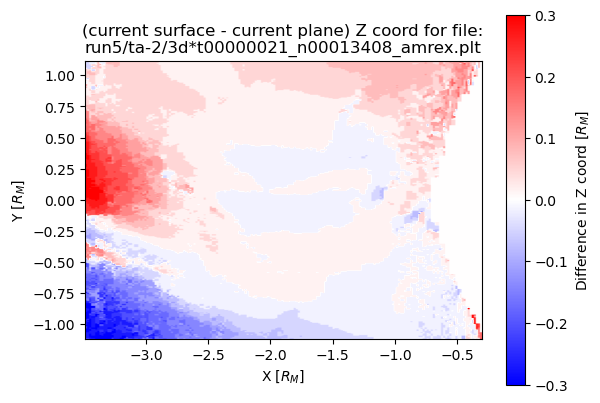

In [11]:
#x_axis = np.unique(xz_plane["XX"])
plt.imshow(current_surface["ZZ"]-current_plane["ZZ"][::grid_skip,::grid_skip],
           origin="lower",extent=[np.min(current_surface["XX"]),np.max(current_surface["XX"]),
                                np.min(current_surface["YY"]),np.max(current_surface["YY"])],
          cmap="bwr")
plt.colorbar(label="Difference in Z coord [$R_M$]")
plt.xlabel("X [$R_M$]")
plt.ylabel("Y [$R_M$]")
plt.title(str("(current surface - current plane) Z coord for file:\nrun5/ta-2/3d*t00000021_n00013408_amrex.plt"))
#plt.plot(x_axis, -normal[0]*(x_axis+2)+origin[2],linewidth=2,color="black",alpha=0.5)


Text(0.5, 1.0, '(current surface - current plane) $B_z$ for file:\nrun5/ta-2/3d*t00000021_n00013408_amrex.plt')

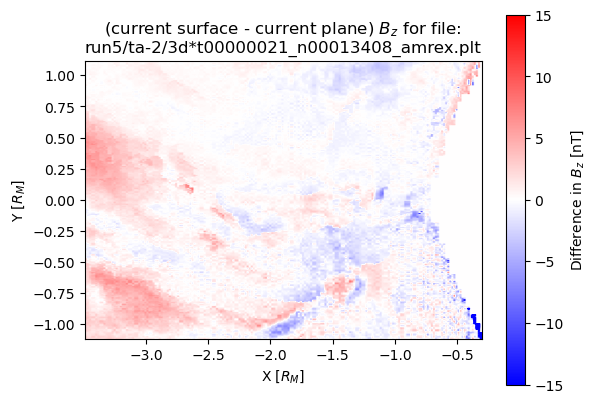

In [12]:
plt.imshow(current_surface["Bz"]-current_plane["Bz"][::grid_skip,::grid_skip],
           origin="lower",extent=[np.min(current_surface["XX"]),np.max(current_surface["XX"]),
                                np.min(current_surface["YY"]),np.max(current_surface["YY"])],
          vmin=-15,vmax=15,cmap="bwr")
plt.colorbar(label="Difference in $B_z$ [nT]")
plt.xlabel("X [$R_M$]")
plt.ylabel("Y [$R_M$]")
plt.title(str("(current surface - current plane) $B_z$ for file:\nrun5/ta-2/3d*t00000021_n00013408_amrex.plt"))

In [97]:
origin[2]

0.18603521585464478

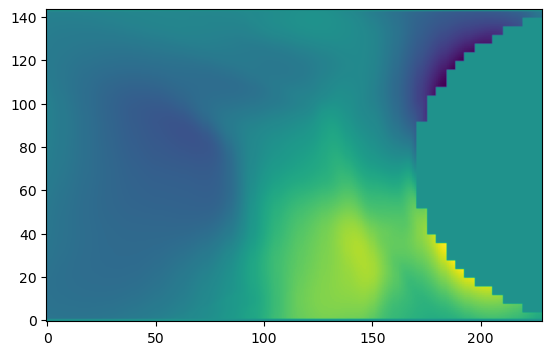

In [71]:
plt.imshow(rho,origin="lower")

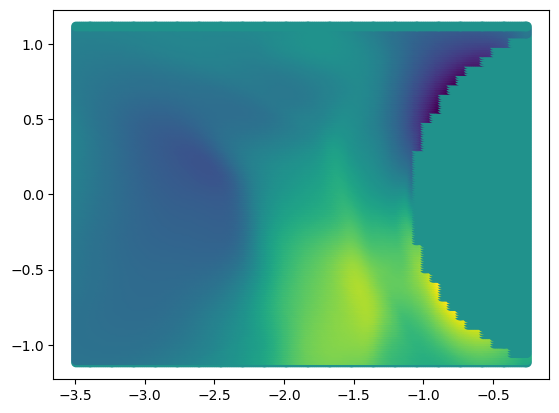

In [69]:
plt.scatter(rect_zone.values("X").as_numpy_array(),rect_zone.values("Y").as_numpy_array(),c=rect_zone.values("By").as_numpy_array())

In [108]:
origin,normal,xz_plane,Jy = find_current_sheet(dataset,return_data=True)

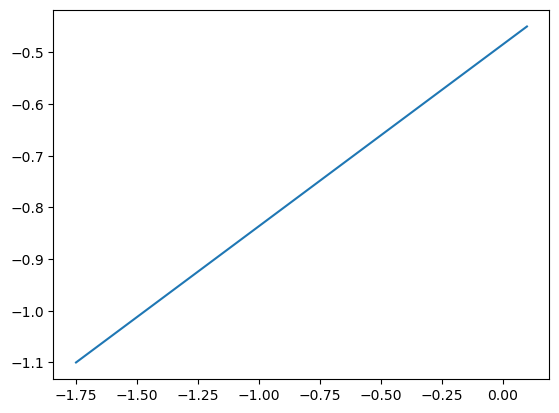

In [12]:
plt.plot(line_start,line_end)

In [81]:
len(np.unique(dataset.variable("X").values('')[:]))

224

In [88]:
data[2]["XX"].shape

(54, 164)

In [90]:
current_sheet["XX"].shape

(144, 214)